# Técnicas de aprendizaje supervisado
## Practica de Intercomparación aplicada a datos meteorológicos
## Santander Meteorology Group

## Abstract
En esta práctica haremos una intercomparación de varias de las técnicas de aprendizaje supervisado vistas a lo largo de la asignatura (CART, k-NN, GLMs y Random Forests). Por tanto, pretende ser un repaso general de cara al examen en el que el objetivo es tratar de entender las ventajas y limitaciones de las distintas técnicas para un caso de aplicación particular; la predicción de precipitación. La entrega consistirá en un notebook (Jupyter o R-Markdown), junto con el archivo html que éste genera. Ambos ficheros se entregarán a través del Moodle de la asignatura en la tarea correspondiente.

## 1 Conjunto de datos meteo

Comenzaremos cargando el dataset meteo, que ya ha sido utilizado en sesiones anteriores. Como ya sabéis, la variable objetivo en este dataset es la precipitation diaria en Lisboa durante el período 1979-2008, y para modelizar ésta se dispone de un conjunto de 8 variables meteorológicas predictoras que describen la circulación de larga escala definidas sobre un dominio geográfico que incluye 40 puntos sobre la Península Ibérica. (en total 8×40=320

variables explicativas). Las variables predictoras son:
- altura geopotencial en 500 hPa (Z500)
- temperatura del aire en los niveles 850 hPa, 700 hPa y 500 hPa (ta850, ta700 y ta500), y en superficie (tas)
- humedad específica del aire en 850 hPa y 500 hPa (hus850, hus500)
- presión a nivel del mar (psl)

Para agilizar los tiempos de cómputo, reduciremos la dimensionalidad del problema. Como ya se ha visto en sesiones anteriores, una alternativa para tal fin es el uso de PCs. Sin embargo, para no limitar la interpretabilidad de los resultados obtenidos con árboles, utilizaremos otra aproximación aquí. En concreto, optaremos por un análisis de correlaciones, en el que se calcula la correlación de Spearman entre nuestra variable objetivo y todas las variables predictoras disponibles. La asunción de partida es que cuanto más fuerte sea esta correlación, mayor es el vínculo físico entre predictando y predictor, y por tanto, más útil es la información que nos aporta ese predictor. Por tanto, este análisis nos permite descartar predictores poco relevantes. Siguiendo esta idea, calcularemos la correlación existente entre nuestro predictando y los 320 predictores, y eliminaremos aquellos con correlaciones entre -0.4 y 0.4. ¿Cuánto se ha reducido la dimensionalidad del problema?

Para simplificar aún más los cálculos, nos limitaremos a los primeros 5000 días del dataset. Como siempre, consideraremos una partición de la muestra en dos subconjuntos independientes, train y test, escogidos aleatoriamente (75% para entrenar y 25% para validar).

### Desarrollo punto 1

In [1]:
# Cargo el dataset
meteo <- read.csv("meteo.csv", row.name = 1)

In [2]:
# Me quedo solo con las variables que tengas correlación con y grande
# |corr(y,Xn)| > 0.4

meteo.slim <- meteo[cor(meteo,  method = "spearman")[1,] > 0.4 | cor(meteo,  method = "spearman")[1,] < -0.4]
ncol(meteo.slim)

[1] 38

Me quedo con solo 38 columnas (variables): la variable objetivo 'y' y 37 predictores.

In [3]:
head(meteo.slim)

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X285,X289,X290,X294,X295,X299,X300,X304,X305,X310
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10.9,57042.96,56534.84,55884.40,55175.59,54458.21,56980.27,56460.59,55800.02,55051.15,⋯,101630.11,101951.2,101637.30,101851.9,101647.36,101771.5,101608.23,101599.4,101552.05,101491.42
2,0.6,56963.20,56493.45,55930.82,55340.20,54768.63,56856.57,56361.95,55776.76,55164.26,⋯,102157.66,102307.5,102222.22,102337.1,102366.47,102384.1,102581.66,102490.5,102765.78,102937.78
3,13.0,56522.59,55971.40,55304.34,54498.03,53725.15,56514.84,55977.71,55327.28,54569.78,⋯,100296.72,101128.8,100516.84,101360.8,100761.91,101570.8,101107.28,101841.0,101525.97,101967.72
4,0.0,54627.98,53979.80,53494.05,53072.98,52616.36,54776.17,54089.05,53516.98,53012.86,⋯,99925.61,100301.7,99681.23,100185.7,99495.23,100173.6,99425.98,100082.4,99530.73,99719.67
5,0.0,53584.38,53391.01,53310.38,53292.82,53340.13,53781.70,53498.13,53306.82,53213.26,⋯,101148.34,100947.7,100945.84,100928.0,100825.59,100927.7,100779.03,100934.7,100809.59,100895.84
6,1.2,54221.86,54220.24,54328.55,54772.49,55251.11,54391.11,54345.93,54284.05,54525.99,⋯,102389.94,102054.1,102339.81,102220.9,102367.25,102249.9,102394.12,102287.2,102379.75,102404.75


In [4]:
# Fijo el seed, para que el sample que uso para separar en train y test
# de siempre el mismo resultado.
set.seed(23)

In [5]:
# Separo en set de train y de test. En total, uso solo los primeros 5000 días del dataset 
n <- 5000

# indice de train
indtrain <- sample(1:n, round(0.75*n)) 
meteo.slim.train <- meteo.slim[indtrain,]

# indice de test
indtest <- setdiff(1:n, indtrain)      
meteo.slim.test  <- meteo.slim[indtest,]

# Dataset de entrenamiento: meteo.slim.train
# Dataset de test:          meteo.slim.test  

## 2 Árboles de clasificación y regresión (2.5 puntos)

Como ya hemos visto en sesiones anteriores, tendremos que crear dos modelos independientes, uno para la clasificación del evento binario lluvia/no lluvia y otro para el evento continuo cantidad de lluvia. Nos centramos en primer lugar en la clasificación lluvia/no lluvia. Para ello, tenemos que crear la variable binaria ocurrencia de precipitación (considera un umbral de 1 mm) y construir el dataframe asociado al problema.

A continuación construiremos el árbol completo (usa la función tree). ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol?

Para simplificar este árbol tan complejo tendremos que podarlo adecuadamente. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

Utiliza este árbol óptimo para predecir en el test. Guarda las predicciones.

Una vez obtenidas las predicciones de ocurrencia pasaremos a estimar la cantidad de precipitación. Primero creamos el dataset correspondiente.

A continuación construiremos dos árboles, uno entrenado sobre todo el conjunto de train y otro entrenado sólo sobre los días de lluvia (en el train). Empezamos por el primero de estos árboles. Construye el árbol completo ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol? ¿Son las mismas que para el caso de la ocurrencia?

Al igual que hicimos para el caso de la ocurrencia, tendremos que podar este árbol tan complejo. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

Utiliza el árbol óptimo que acabas de encontrar para predecir en el test, y conserva la predicción obtenida

Repite el mismo proceso para el segundo árbol de regresión (el que sólo se entrena sobre los días de lluvia en el train).

Obtén las dos series predichas completas para el test (la secuencia lluvia/no lluvia será la misma en las dos) y valida tus resultados en función de las siguiente métricas:

- Para la parte binaria lluvia/no lluvia: Accuracy.
- Para la serie completa: RMSE, correlación de Spearman y ratio de varianzas.

Pregunta: ¿Cuál de los dos árboles da mejores resultados? ¿Por qué?

### Desarrollo punto 2

Como ya hemos visto en sesiones anteriores, tendremos que crear dos modelos independientes, uno para la clasificación del evento binario lluvia/no lluvia y otro para el evento continuo cantidad de lluvia. Nos centramos en primer lugar en la clasificación lluvia/no lluvia. Para ello, tenemos que crear la variable binaria ocurrencia de precipitación (considera un umbral de 1 mm) y construir el dataframe asociado al problema.



In [6]:
# converto la variable objetivo en categórica
rain = ifelse(meteo.slim$y < 1, 0, 1)
meteo.slim$rain = as.factor(rain)

A continuación construiremos el árbol completo (usa la función tree). ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol?

In [7]:
# Cargo la libreria necesaria para usar los trees
library(tree)

In [8]:
# Quito 'y' y me quedo solo con 'rain' 
meteo.rain <- meteo.slim[,2:ncol(meteo.slim)]

In [9]:
head(meteo.rain)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X289,X290,X294,X295,X299,X300,X304,X305,X310,rain
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,57042.96,56534.84,55884.40,55175.59,54458.21,56980.27,56460.59,55800.02,55051.15,54318.77,⋯,101951.2,101637.30,101851.9,101647.36,101771.5,101608.23,101599.4,101552.05,101491.42,1
2,56963.20,56493.45,55930.82,55340.20,54768.63,56856.57,56361.95,55776.76,55164.26,54585.32,⋯,102307.5,102222.22,102337.1,102366.47,102384.1,102581.66,102490.5,102765.78,102937.78,0
3,56522.59,55971.40,55304.34,54498.03,53725.15,56514.84,55977.71,55327.28,54569.78,53863.46,⋯,101128.8,100516.84,101360.8,100761.91,101570.8,101107.28,101841.0,101525.97,101967.72,1
4,54627.98,53979.80,53494.05,53072.98,52616.36,54776.17,54089.05,53516.98,53012.86,52501.42,⋯,100301.7,99681.23,100185.7,99495.23,100173.6,99425.98,100082.4,99530.73,99719.67,0
5,53584.38,53391.01,53310.38,53292.82,53340.13,53781.70,53498.13,53306.82,53213.26,53157.38,⋯,100947.7,100945.84,100928.0,100825.59,100927.7,100779.03,100934.7,100809.59,100895.84,0
6,54221.86,54220.24,54328.55,54772.49,55251.11,54391.11,54345.93,54284.05,54525.99,55012.61,⋯,102054.1,102339.81,102220.9,102367.25,102249.9,102394.12,102287.2,102379.75,102404.75,1


[1] "El arbol completo tiene 320 hojas"


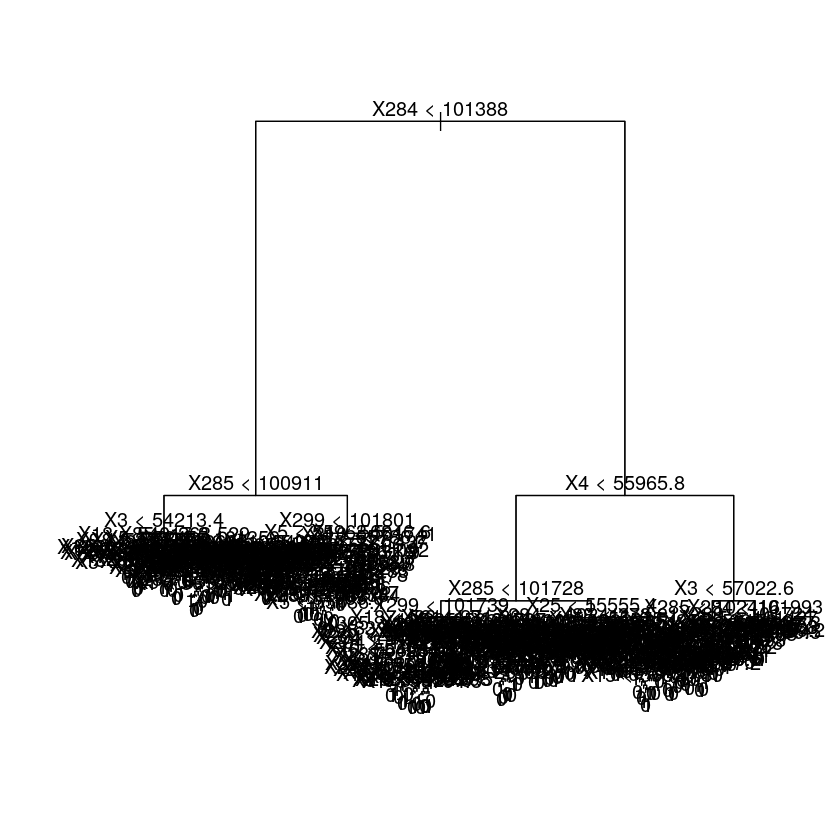

In [10]:
# Entreno un arbol que dejo crecer sin limites
t.tree = tree(formula = rain ~ ., 
              data = meteo.rain, 
              subset = indtrain, 
              control = tree.control(length(indtrain), 
                                     mincut = 1, 
                                     minsize = 2, 
                                     mindev = 0))

# Pinto el arbol
plot(t.tree)
text(t.tree, pretty = F)

# Cuento las hojas terminales
print(paste("El arbol completo tiene",
length(t.tree$frame$var[t.tree$frame$var == '<leaf>']), "hojas"))

Las primeras variables utilizadas por el arbol son:
- presión a nivel del mar (X284, X285);
- Altura geopotencial en 500 hPa (X3, X4).

Para simplificar este árbol tan complejo tendremos que podarlo adecuadamente. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

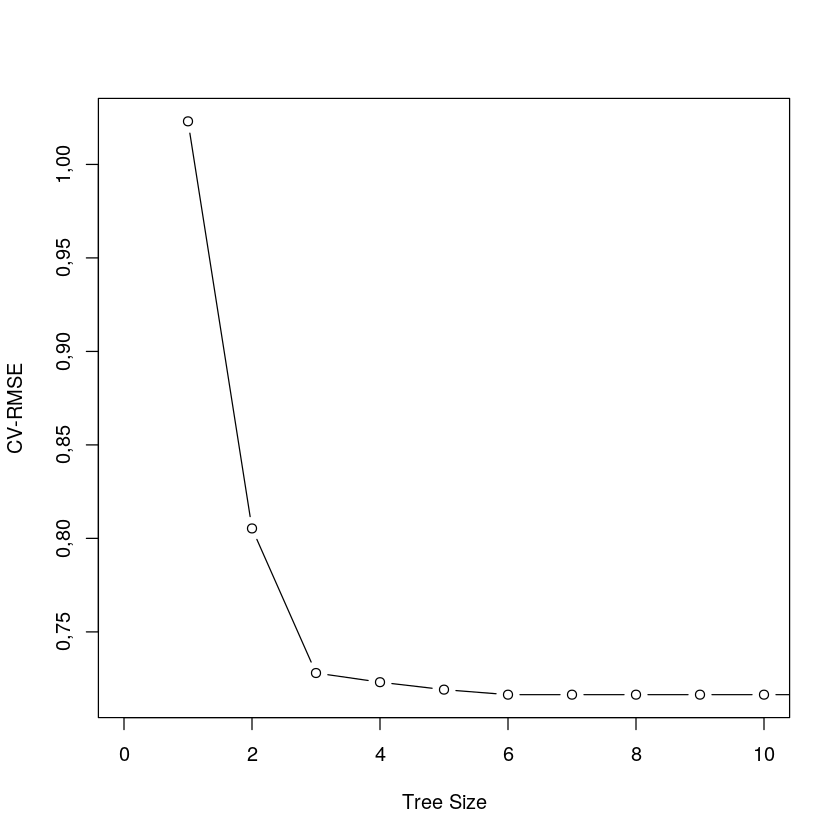

In [11]:
# Ahora uso cross-validation para podar el arbol completo,
# haciendo que sea más generalizable, o más útil para predecir

# Preparo la validación cruzada
tree.cv <- cv.tree(object = t.tree,
                    FUN = prune.tree,
                    K = 10)

# Pinto la accuracy en función de la profundidad
plot(tree.cv$size, tree.cv$dev / length(indtrain), type = "b",
     xlab = "Tree Size", ylab = "CV-RMSE",
     xlim = c(0,10))

Parece que con tan solo 6 hojas, ya tenemos la minima desviación: podamos el arbol.


Classification tree:
snip.tree(tree = t.tree, nodes = c(15L, 13L, 5L, 12L, 4L, 14L
))
Variables actually used in tree construction:
[1] "X284" "X285" "X4"   "X3"  
Number of terminal nodes:  6 
Residual mean deviance:  0,6786 = 2540 / 3744 
Misclassification error rate: 0,1461 = 548 / 3750 

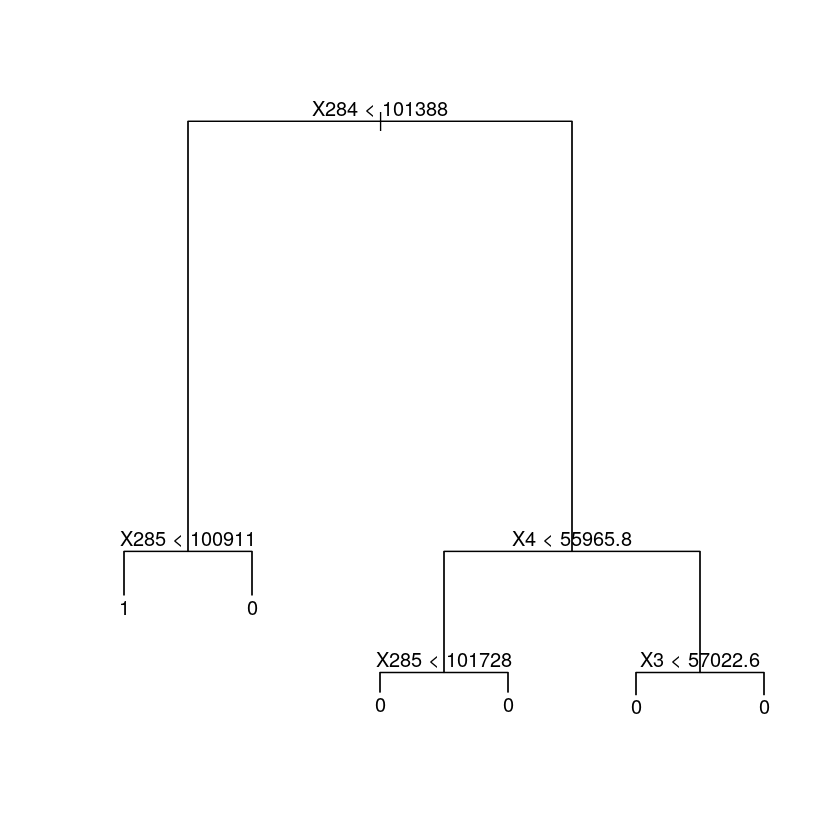

In [12]:
# Podo el arbol completo según lo resultados de la validación cruzada
opt.tree <- prune.tree(t.tree, best = 6)

# Pinto el arbol optimo
plot(opt.tree)
text(opt.tree, pretty = F)

summary(opt.tree)

Los predictores más importantes son los primeros que se encuentran en el arbol completo (solo hemos podado ese arbol, al fin y a cabo):
- presión a nivel del mar (X284, X285);
- Altura geopotencial en 500 hPa (X5).

Utiliza este árbol óptimo para predecir en el test. Guarda las predicciones.

In [13]:
# Preparo los dataset de train y de test
meteo.rain.train <- meteo.rain[indtrain,]
meteo.rain.test <- meteo.rain[-indtrain,]

# Guardo las predicciones del arbol optimo
pred.train = predict(opt.tree, newdata = meteo.rain.train, type = "class")
pred.test  = predict(opt.tree, newdata = meteo.rain.test, type = "class")

Una vez obtenidas las predicciones de ocurrencia pasaremos a estimar la cantidad de precipitación. Primero creamos el dataset correspondiente.

In [14]:
# Preparo el dataset de entrenamiento que tenga solo los días de lluvia
# 'cont' en el nombre significa ~continuo (la lluvia ya no es un factor)

meteo.cont.rain <- meteo.slim[meteo.slim$rain == 1,]
meteo.cont.rain <- meteo.cont.rain[1:ncol(meteo.cont.rain)-1]
head(meteo.cont.rain)
nrow(meteo.cont.rain)

# Preparo el dataset de entrenamiento que tenga 
# tanto los días sin lluvia como los días sin lluvia
# 'cont' en el nombre significa ~continuo (la lluvia ya no es un factor)

meteo.cont <- meteo.slim[1:ncol(meteo.slim)-1]
head(meteo.cont)
nrow(meteo.cont)

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X285,X289,X290,X294,X295,X299,X300,X304,X305,X310
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"10,9","57042,96","56534,84","55884,40","55175,59","54458,21","56980,27","56460,59","55800,02","55051,15",⋯,"101630,1","101951,2","101637,3","101851,9","101647,4","101771,5","101608,2","101599,4","101552,0","101491,4"
3,"13,0","56522,59","55971,40","55304,34","54498,03","53725,15","56514,84","55977,71","55327,28","54569,78",⋯,"100296,7","101128,8","100516,8","101360,8","100761,9","101570,8","101107,3","101841,0","101526,0","101967,7"
6,"1,2","54221,86","54220,24","54328,55","54772,49","55251,11","54391,11","54345,93","54284,05","54525,99",⋯,"102389,9","102054,1","102339,8","102220,9","102367,2","102249,9","102394,1","102287,2","102379,8","102404,8"
7,"1,1","54665,38","54762,01","54962,26","55313,45","55764,88","54783,82","54841,70","55008,95","55257,01",⋯,"102591,2","102209,3","102559,7","102502,0","102637,2","102643,4","102760,0","102857,0","102870,7","102965,4"
17,"21,7","55025,95","54964,57","54946,76","54885,26","54781,63","55253,51","55115,38","55012,76","54893,01",⋯,"101490,3","101432,2","101488,5","101638,5","101539,3","101677,3","101589,5","101703,3","101614,3","101668,4"
18,"23,7","54123,27","53874,02","53679,64","53482,08","53106,45","54377,20","54092,64","53827,64","53565,64",⋯,"100172,5","100049,6","100118,5","100297,0","100138,6","100430,8","100206,0","100618,2","100362,8","100607,3"


[1] 2225

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X285,X289,X290,X294,X295,X299,X300,X304,X305,X310
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"10,9","57042,96","56534,84","55884,40","55175,59","54458,21","56980,27","56460,59","55800,02","55051,15",⋯,"101630,11","101951,2","101637,30","101851,9","101647,36","101771,5","101608,23","101599,4","101552,05","101491,42"
2,"0,6","56963,20","56493,45","55930,82","55340,20","54768,63","56856,57","56361,95","55776,76","55164,26",⋯,"102157,66","102307,5","102222,22","102337,1","102366,47","102384,1","102581,66","102490,5","102765,78","102937,78"
3,"13,0","56522,59","55971,40","55304,34","54498,03","53725,15","56514,84","55977,71","55327,28","54569,78",⋯,"100296,72","101128,8","100516,84","101360,8","100761,91","101570,8","101107,28","101841,0","101525,97","101967,72"
4,"0,0","54627,98","53979,80","53494,05","53072,98","52616,36","54776,17","54089,05","53516,98","53012,86",⋯,"99925,61","100301,7","99681,23","100185,7","99495,23","100173,6","99425,98","100082,4","99530,73","99719,67"
5,"0,0","53584,38","53391,01","53310,38","53292,82","53340,13","53781,70","53498,13","53306,82","53213,26",⋯,"101148,34","100947,7","100945,84","100928,0","100825,59","100927,7","100779,03","100934,7","100809,59","100895,84"
6,"1,2","54221,86","54220,24","54328,55","54772,49","55251,11","54391,11","54345,93","54284,05","54525,99",⋯,"102389,94","102054,1","102339,81","102220,9","102367,25","102249,9","102394,12","102287,2","102379,75","102404,75"


[1] 10958

A continuación construiremos dos árboles, uno entrenado sobre todo el conjunto de train y otro entrenado sólo sobre los días de lluvia (en el train). Empezamos por el primero de estos árboles. Construye el árbol completo ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol? ¿Son las mismas que para el caso de la ocurrencia?

Utiliza el árbol óptimo que acabas de encontrar para predecir en el test, y conserva la predicción obtenida.
Repite el mismo proceso para el segundo árbol de regresión (el que sólo se entrena sobre los días de lluvia en el train).

### Uso todos los eventos

[1] "El arbol completo tiene 959 hojas"


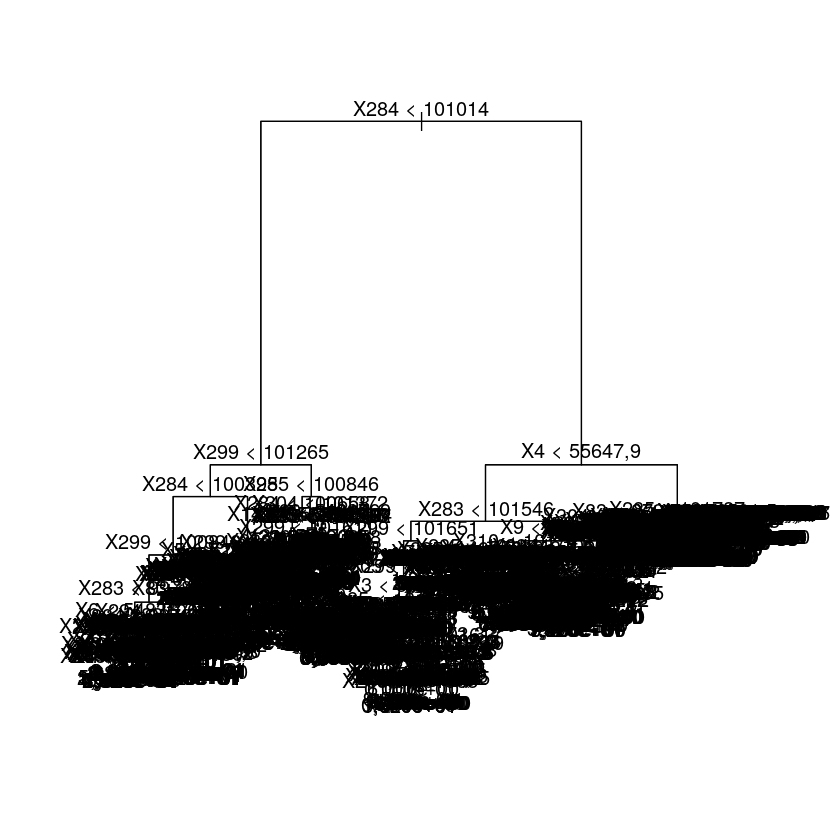

In [15]:
# Entreno un arbol que dejo crecer sin limites
# Uso el dataset de entrenamiento completo

full.tree = tree(formula = y ~ ., 
              data = meteo.cont, 
              subset = indtrain, 
              method = "cubist",                 
              control = tree.control(length(indtrain), 
                                     mincut = 1, 
                                     minsize = 2, 
                                     mindev = 0))

# Pinto el arbol
plot(full.tree)
text(full.tree, pretty = F)

# Cuento las hojas terminales
print(paste("El arbol completo tiene",
length(full.tree$frame$var[full.tree$frame$var == '<leaf>']), "hojas"))

Las primeras variables encontradas en el entrenamiento del arbol completo son parecidas al caso de clasficación (lluvia/no lluvia):
- Presión a nivel del mar (X299, X284, X283);
- Altura geopotencial en 500 hPa (X4),

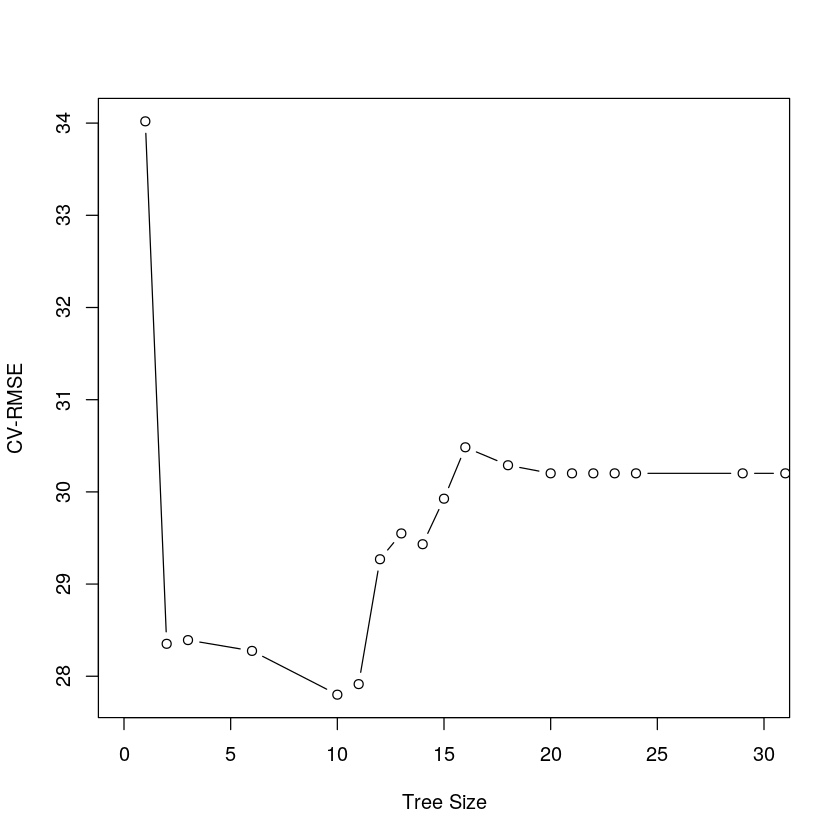

In [16]:
# Ahora uso cross-validation para podar el arbol completo,
# haciendo que sea más generalizable, o más útil para predecir

# Preparo la validación cruzada
full.tree.cv <- cv.tree(object = full.tree,
                    FUN = prune.tree,
                    K = 10)

# Pinto la accuracy en función de la profundidad
plot(full.tree.cv$size, full.tree.cv$dev / length(indtrain), type = "b",
     xlab = "Tree Size", ylab = "CV-RMSE",
     xlim = c(0,30))


Regression tree:
snip.tree(tree = full.tree, nodes = c(7L, 100L, 9L, 13L, 24L, 
5L, 16L, 17L, 51L))
Variables actually used in tree construction:
[1] "X284" "X299" "X4"   "X283"
Number of terminal nodes:  10 
Residual mean deviance:  21,01 = 78590 / 3740 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-23,3600  -1,0510  -0,3378   0,0000  -0,3378  51,5600 

node), split, n, deviance, yval
      * denotes terminal node

  1) root 3750 127500,0  1,9250  
    2) X284 < 101014 410  48670,0  9,1260  
      4) X299 < 101265 342  35110,0  8,0900  
        8) X284 < 100395 139  21120,0 12,2500  
         16) X299 < 100846 117  12620,0 10,1500 *
         17) X299 > 100846 22   5215,0 23,4600 *
        9) X284 > 100395 203   9934,0  5,2390 *
      5) X299 > 101265 68  11340,0 14,3400 *
    3) X284 > 101014 3340  54990,0  1,0410  
      6) X4 < 55647,9 988  43750,0  2,7150  
       12) X283 < 101546 315  25670,0  4,4270  
         24) X299 < 101651 248   7717,0  2,9270 *
         25) X299 > 101651 67  15330,0  9,9790  
           50) X299 < 101670 4   5173,0 36,0800  
            100) X4 < 55383,4 3    464,2 16,2700 *
            101) X4 > 55383,4 1      0,0 95,5000 *
           51) X299 > 101670 63   7264,0  8,3220 *
       13) X283 > 101546 673  16720,0  1,9140 *
      7) X4 > 55647,9 2352   7314,0  0,3378 *


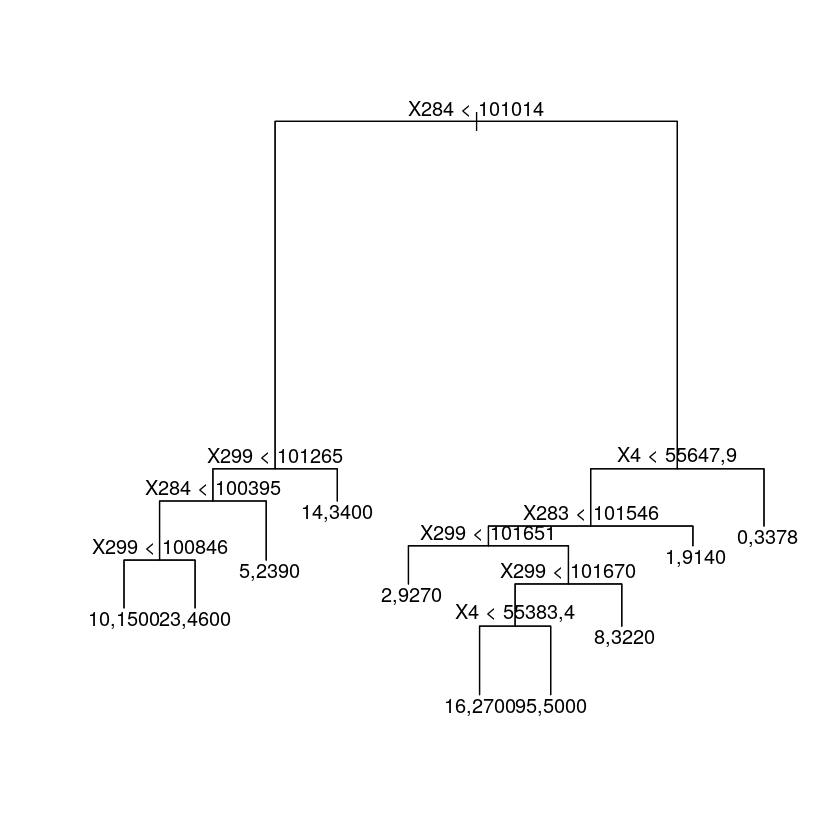

In [17]:
# Podo el arbol completo según lo resultados de la validación cruzada
opt.tree.full <- prune.tree(full.tree, best = 10)

# Pinto el arbol optimo
plot(opt.tree.full)
text(opt.tree.full, pretty = F)

summary(opt.tree.full)

print(opt.tree.full)

In [18]:
# Preparo los dataset de train y de test
meteo.cont.full.train <- meteo.cont[indtrain,]
meteo.cont.full.test <- meteo.cont[-indtrain,]

# Guardo las predicciones del arbol optimo entrenado con todos los eventos (full)
pred.cont.full.train = predict(opt.tree.full, newdata = meteo.cont.full.train)
pred.cont.full.test  = predict(opt.tree.full, newdata = meteo.cont.full.test)

### Uso solo los eventos con lluvia

[1] "El arbol completo entrenado solo con días de lluvia tiene 1187 hojas"


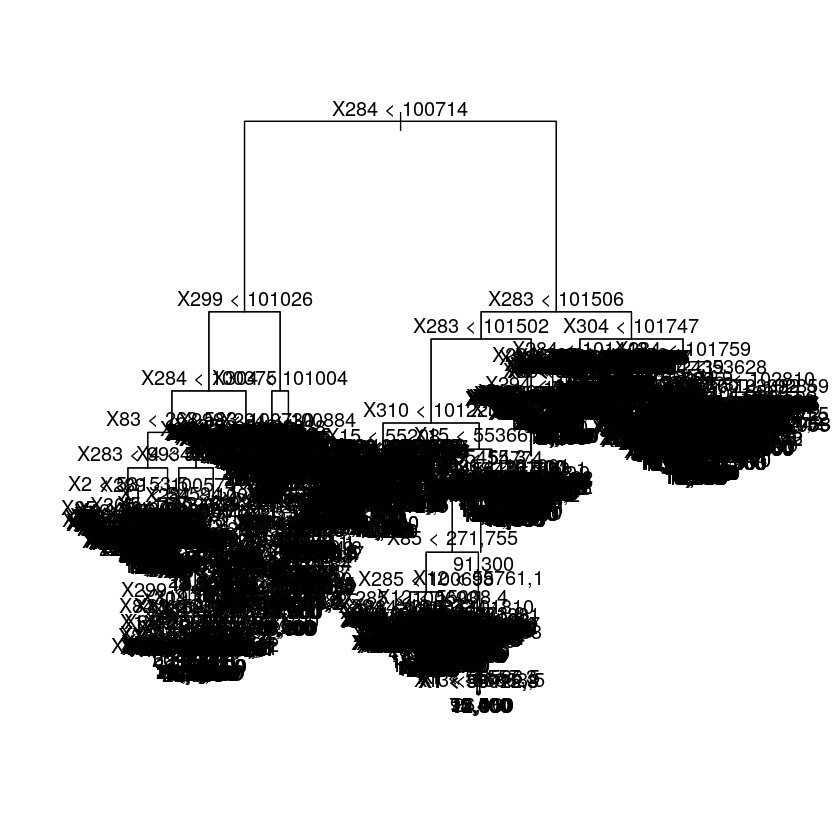

In [69]:
# Entreno un arbol que dejo crecer sin limites
# Uso el dataset de entrenamiento con solo días de lluvia

rain.tree = tree(formula = y ~ ., 
              data = meteo.cont.rain, 
              subset = indtrain, 
              method = "cubist", # uso el método cubist para obtener predicciones continuas
              control = tree.control(length(indtrain), 
                                     mincut = 1, 
                                     minsize = 2, 
                                     mindev = 0))

# Pinto el arbol
plot(rain.tree)
text(rain.tree, pretty = F)

# Cuento las hojas terminales
print(paste("El arbol completo entrenado solo con días de lluvia tiene",
length(rain.tree$frame$var[rain.tree$frame$var == '<leaf>']), "hojas"))

En este caso, las primeras variables encontradas en el entrenamiento del arbol completo son principalmente 
relacionadas con la presión a nivel del mar (X299, X283, X304).


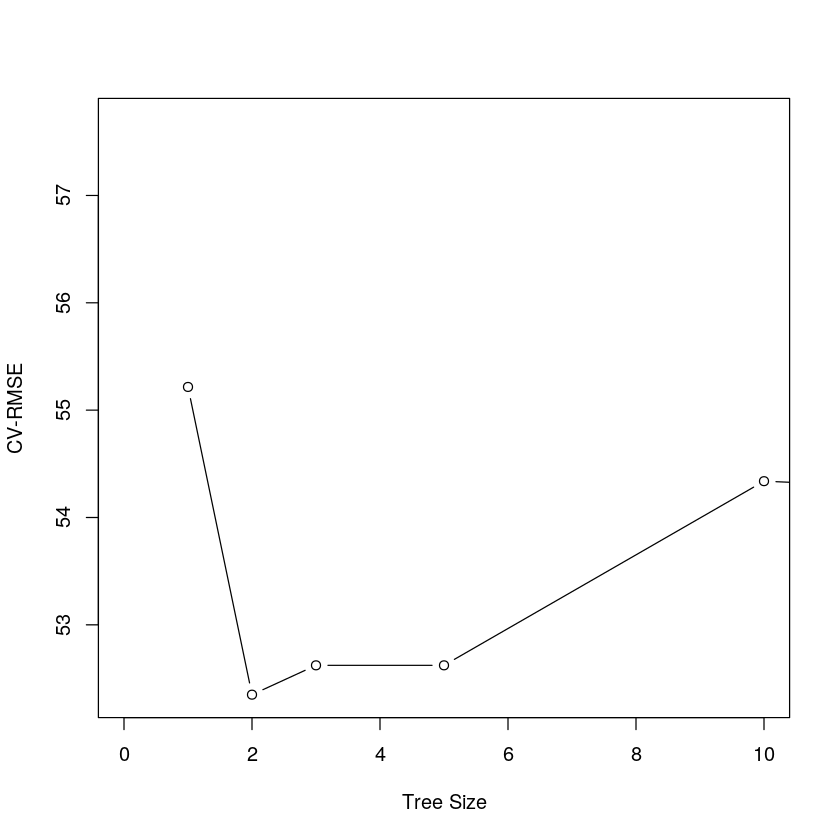

In [20]:
# Ahora uso cross-validation para podar el arbol completo,
# haciendo que sea más generalizable, o más útil para predecir

# Preparo la validación cruzada
rain.tree.cv <- cv.tree(object = rain.tree,
                    FUN = prune.tree,
                    K = 10)

# Pinto la accuracy en función de la profundidad
plot(rain.tree.cv$size, rain.tree.cv$dev / length(indtrain), type = "b",
     xlab = "Tree Size", ylab = "CV-RMSE",
     xlim = c(0,10))

node), split, n, deviance, yval
      * denotes terminal node

 1) root 1665 206800  9,758  
   2) X284 < 100714 447  88090 14,630  
     4) X299 < 101026 358  53070 12,800 *
     5) X299 > 101026 89  29000 21,990 *
   3) X284 > 100714 1218 104200  7,969  
     6) X283 < 101506 581  62910  9,336  
      12) X283 < 101502 579  54020  9,141 *
      13) X283 > 101502 2   2492 65,800 *
     7) X283 > 101506 637  39180  6,723 *


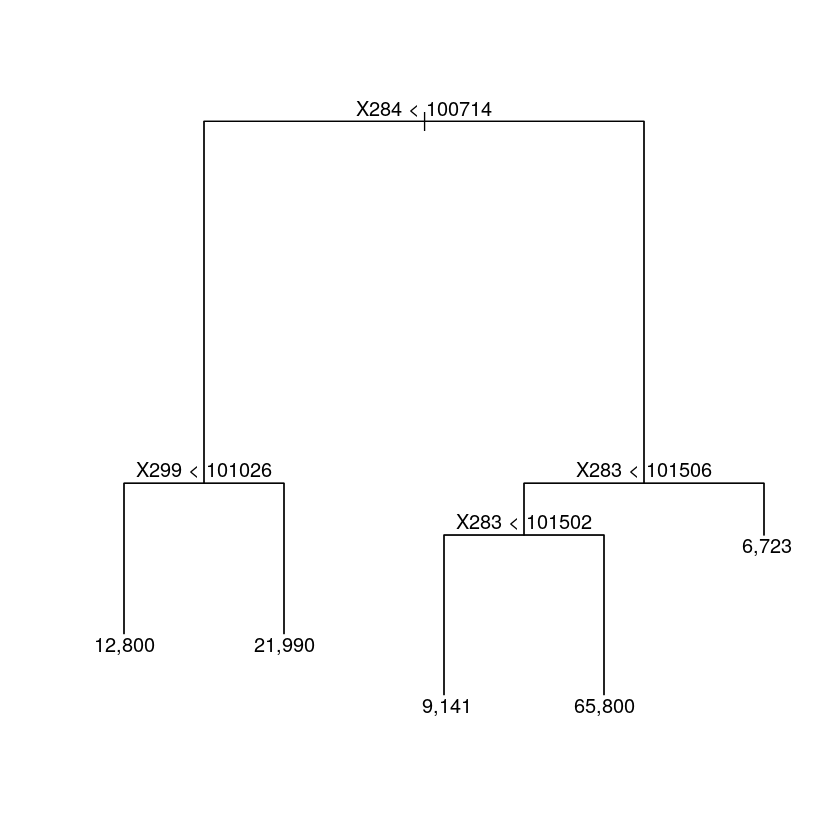

In [21]:
# Podo el arbol completo según lo resultados de la validación cruzada
# Vemos que el arbol optimo deberia tener 5 hojas finales.
opt.tree.rain <- prune.tree(rain.tree, best = 5)

# Pinto el arbol optimo
plot(opt.tree.rain)
text(opt.tree.rain, pretty = F)
print(opt.tree.rain)

node), split, n, deviance, yval
      * denotes terminal node

  1) root 1665 206800,0  9,758  
    2) X284 < 100714 447  88090,0 14,630  
      4) X299 < 101026 358  53070,0 12,800 *
      5) X299 > 101026 89  29000,0 21,990 *
    3) X284 > 100714 1218 104200,0  7,969  
      6) X283 < 101506 581  62910,0  9,336  
       12) X283 < 101502 579  54020,0  9,141  
         24) X310 < 101223 259  13460,0  7,077 *
         25) X310 > 101223 320  38560,0 10,810  
           50) X15 < 55366,8 192  30540,0 12,650  
            100) X5 < 55455,3 191  24320,0 12,240  
              200) X85 < 271,755 183  13220,0 11,410 *
              201) X85 > 271,755 8   8066,0 31,290  
                402) X12 < 55761,1 2    244,2 84,450 *
                403) X12 > 55761,1 6    285,2 13,570 *
            101) X5 > 55455,3 1      0,0 91,300 *
           51) X15 > 55366,8 128   6395,0  8,049 *
       13) X283 > 101502 2   2492,0 65,800 *
      7) X283 > 101506 637  39180,0  6,723 *


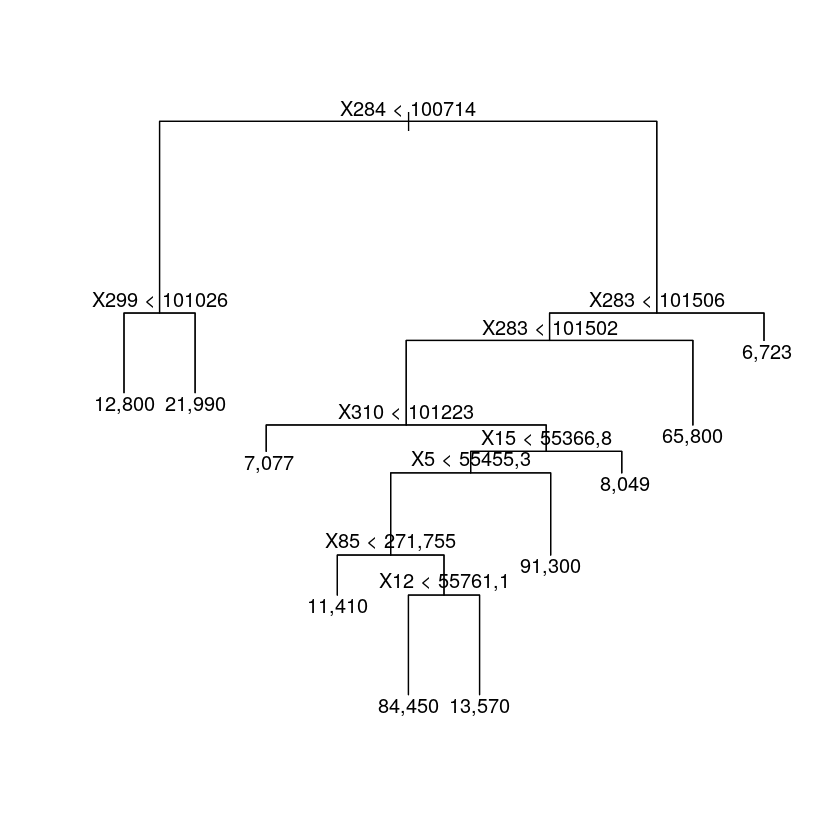

In [22]:
# Podriamos pensar que la usar solo 5 hojas implique
# reducir la acpacidad del arbol en describir la variabilidad 
# de la cantidad de lluvia. Intentamos usar 10 hojas
opt.tree.rain.10 <- prune.tree(rain.tree, best = 10)

# Pinto el arbol optimo
plot(opt.tree.rain.10)
text(opt.tree.rain.10, pretty = F)
print(opt.tree.rain.10)

In [72]:
# Preparo los dataset de train y de test
meteo.cont.rain.train <- na.omit(meteo.cont.rain[indtrain,])
meteo.cont.rain.test  <- na.omit(meteo.cont.rain[-indtrain,])

# Guardo las predicciones del arbol optimo
pred.cont.rain.test.all = predict(opt.tree.rain, newdata = meteo.cont.full.test)
pred.cont.rain.test     = predict(opt.tree.rain, newdata = meteo.cont.full.test)

# Guardo las predicciones del arbol con 10 hojas
pred.cont.rain.test.all.10 = predict(opt.tree.rain.10, newdata = meteo.cont.full.test)
pred.cont.rain.test.10     = predict(opt.tree.rain.10, newdata = meteo.cont.full.test)

Obtén las dos series predichas completas (multiplico la predicción de lluvia/no lluvia por la cantidad de lluvia) para el test (la secuencia lluvia/no lluvia será la misma en las dos) y valida tus resultados en función de las siguiente métricas:

- Para la parte binaria lluvia/no lluvia: Accuracy.
- Para la serie completa: RMSE, correlación de Spearman y ratio de varianzas.

Pregunta: ¿Cuál de los dos árboles da mejores resultados? ¿Por qué?

### Arbol de clasificación: accuracy

In [24]:
# Mido el accuracy de la classificación binaria lluvia/no-lluvia
print("Accuracy de la clasificación lluvia/no-lluvia")
100*sum(diag(table(meteo.rain.test[,"rain"], pred.test))) / length(pred.test)

[1] "Accuracy de la clasificación lluvia/no-lluvia"


[1] 85,6687

In [25]:
# Miro también 'a ojo' las primeras 20 predicciones, comparadas con el dataset original de test
meteo.rain.test[1:20,"rain"]
pred.test[1:20]

[1] 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
Levels: 0 1

[1] 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0
Levels: 0 1

In [26]:
# Y la matriz de confusión, para evaluar los falsos positivos/negativos
table(pred.test, meteo.rain.test$rain)

table(pred.test)
table(meteo.rain.test$rain)

         
pred.test    0    1
        0 5525  795
        1  238  650

pred.test
   0    1 
6320  888 


   0    1 
5763 1445 

### Arbol de regresión: RMSE, correlación, ratio de varianzas

#### 1. Empiezo por el arbol entrenado con días de lluvia y días sin lluvia

[1] 5,859338

[1] 0,524117

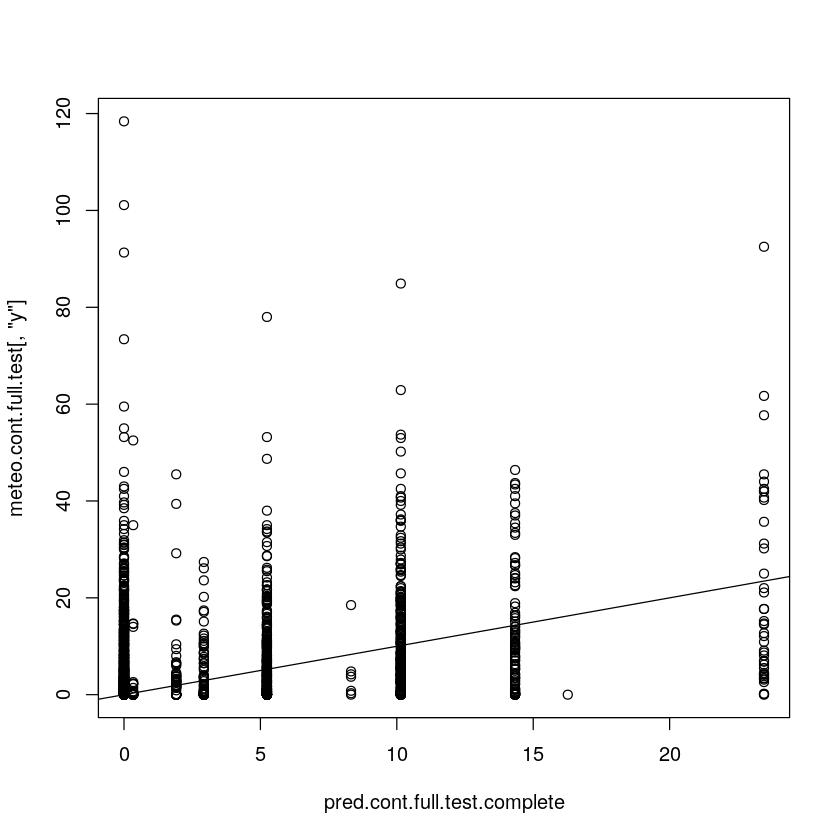

In [27]:
# Construyo la predicción completa
pred.test.num <- as.numeric(pred.test) - 1
pred.cont.full.test.complete <- pred.test.num*pred.cont.full.test

# Pinto los valores original contra la predicción
plot(pred.cont.full.test.complete, meteo.cont.full.test[,'y'])
abline(0,1)

# RMSE - mejor si es baja
rmse.full <- sqrt(mean((meteo.cont.full.test[,'y'] - pred.cont.full.test.complete)^2))
rmse.full

# Correlación - mejor si es alta
corr.full <- cor(meteo.cont.full.test[,'y'], pred.cont.full.test.complete,  method = "spearman")
corr.full

#### 2. Ahora el arbol entrenado solo con días de lluvia

[1] 5,991704

[1] 0,5226632

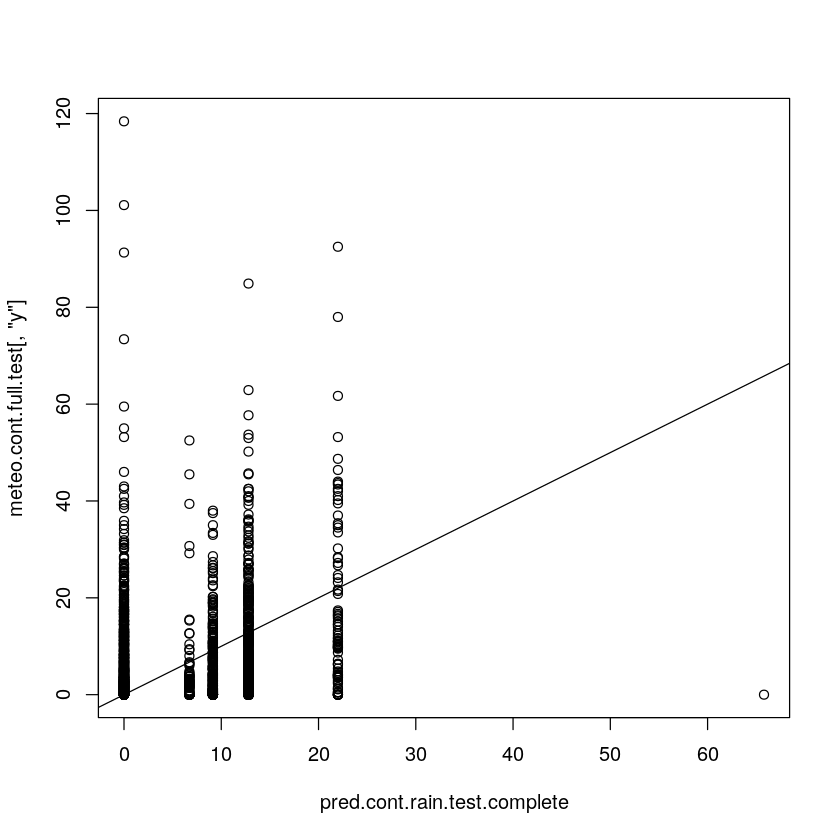

In [28]:
# Construyo la predicción completa
pred.test.num <- as.numeric(pred.test) - 1
pred.cont.rain.test.complete <- pred.test.num*pred.cont.rain.test

# Pinto los valores original contra la predicción
plot(pred.cont.rain.test.complete, meteo.cont.full.test[,'y'])
abline(0,1)

# RMSE - mejor si es baja
rmse.rain <- sqrt(mean((meteo.cont.full.test[,'y'] - pred.cont.rain.test.complete)^2))
rmse.rain

# Correlación - mejor si es alta
corr.rain <- cor(meteo.cont.full.test[,'y'], pred.cont.rain.test.complete,  method = "spearman")
corr.rain

[1] 6,095741

[1] 0,5231861

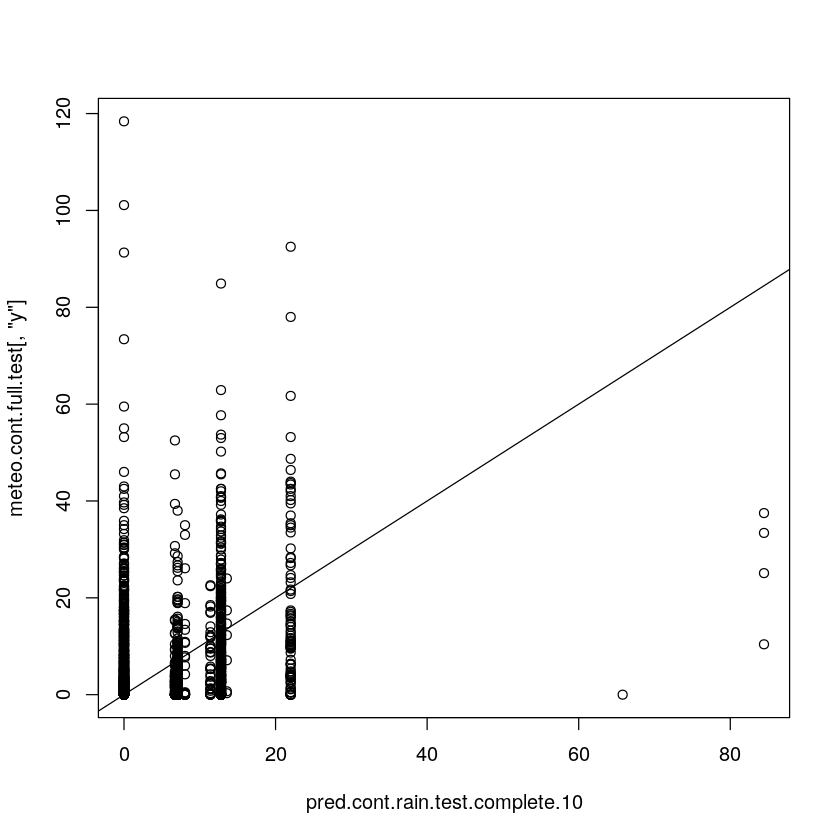

In [29]:
# Lo mismo, pero con el arbol de 10 hoajs

# Construyo la predicción completa
pred.test.num <- as.numeric(pred.test) - 1
pred.cont.rain.test.complete.10 <- pred.test.num*pred.cont.rain.test.10

# Pinto los valores original contra la predicción
plot(pred.cont.rain.test.complete.10, meteo.cont.full.test[,'y'])
abline(0,1)

# RMSE - mejor si es baja
rmse.rain <- sqrt(mean((meteo.cont.full.test[,'y'] - pred.cont.rain.test.complete.10)^2))
rmse.rain

# Correlación - mejor si es alta
corr.rain <- cor(meteo.cont.full.test[,'y'], pred.cont.rain.test.complete.10,  method = "spearman")
corr.rain

### Interpretación de los resultados

Los dos arboles saben predecir la cantidad de lluvia de manera parecida.

Esto no es algo esperado, ya que la idea de entrenar un arbol sólo con días de lluvia se basa en asumir que de esta manera el arbol tenga mayor capacidad de describir la variabilidad de la cantidad de lluvia, mientras que el arbol entrenado con días de lluvia y días sin lluvia debería presentar un porcentage significativo de las hojas prediciendo solo los días de lluvia.

Como se puede apreciar mirando las representaciones de los arboles podados de acuerdo con los resultados de la validación cruzada, ninguna hoja del árbol entrenado con todas la precipitaciones predice un 0, de manera que la capacidad de predecir la cantidad de lluvia es la misma que la del arbol que solo ha sido entrenado con días de lluvia mayor que 1mm.

Por otro lado, el arbol entrenado para clasificar entre días de lluvia y días sin lluvia tiene una buena accuracy (85%). No obstante, los falsos negativos (días de lluvia clasificados como días sin lluvia) resultan tan abundantes como los verdaderos positivos:
- falsos negativos: 795;
- verdaderos positivos: 650.

Esto quiere decir que el arbol prefiere clasificar días de lluvia como días sin lluvia. En particular, que un día de lluvia puede ser clasificado correctamente con una probabilidad inferior al 50%.

## 3 Random forests (2.5 puntos)

A continuación vamos a realizar el mismo ejercicio pero sustituyendo árboles individuales por random forests, empleando para ello en este ejercicio la técnica de “bagging”. Empecemos con el evento ocurrencia. Para estimar cuál sería el tamaño óptimo de nuestro random forest, prueba bosques de hasta 1000 árboles (utiliza la función randomForest) y plotea los errores “Out-Of-Bag” (OOB). ¿Con cuántos árboles te quedarías?

Nota: Hemos visto en la teoría que además del número de árboles, el otro parámetro a ajustar en los random forests es el número de predictores que se consideran en cada nodo para el splitting. En este ejemplo utlizaremos los valores típicos; $\sqrt{n}$
en problemas de clasificación y n/3 en problemas de predicción (siendo n el número total de predictores disponibles).

Utiliza el bosque de tamaño óptimo parar predecir la ocurrencia en el test, y conserva la predicción.

Seguidamente, tal y como hicimos con los árboles individuales, vamos a crear dos random forests para la cantidad, uno que se entrene sobre todo el dataset de train y otro que se entrene sólo sobre los días de lluvia (en el train). De nuevo, tendrás que estimar cuál es el número óptimo de árboles en cada uno de ellos (prueba bosques de hasta 1000 árboles). ¿Qué tamaños óptimos obtienes?

Utiliza los bosques óptimos encontrados para predecir la cantidad en el test, y conserva las predicciones obtenidas.

Construye las predicciones completas (ocurrencia×cantidad) de test y valídalas en función de las mismas métricas utilizadas en el apartado anterior.

Pregunta: Compara estos resultados con los obtenidos para árboles individuales. ¿Qué conclusiones obtienes de la comparación entre árboles individuales y random forests?

### Desarrollo punto 3

In [30]:
library(randomForest)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



In [31]:
# Ya tengo los datasets de entrenamiento y de test listos:

# Clasificación:
# - Todos los días (lluvia y no-lluvia):
#   - entrenamiento: meteo.rain.train
#   - test: meteo.rain.test



# Predicción continua:
# - Todos los días (lluvia y no-lluvia):
#   - entrenamiento: meteo.cont.full.train
#   - test: meteo.cont.full.test

# - Solo días de lluvia:
#   - entrenamiento: meteo.cont.rain.train
#   - test: meteo.cont.rain.test

A continuación vamos a realizar el mismo ejercicio pero sustituyendo árboles individuales por random forests, empleando para ello en este ejercicio la técnica de “bagging”. Empecemos con el evento ocurrencia. Para estimar cuál sería el tamaño óptimo de nuestro random forest, prueba bosques de hasta 1000 árboles (utiliza la función randomForest) y plotea los errores “Out-Of-Bag” (OOB). ¿Con cuántos árboles te quedarías?

Nota: Hemos visto en la teoría que además del número de árboles, el otro parámetro a ajustar en los random forests es el número de predictores que se consideran en cada nodo para el splitting. En este ejemplo utlizaremos los valores típicos; $\sqrt{𝑛}$
en problemas de clasificación y n/3 en problemas de predicción (siendo n el número total de predictores disponibles).

In [32]:
# Entreno un random forest para predecir la ocurrencia de la lluvia

rf <- randomForest(rain ~ ., 
                   data = meteo.rain.train,
                   ntree = 1000,
                   importance=TRUE,
                   proximity=TRUE)
rf


Call:
 randomForest(formula = rain ~ ., data = meteo.rain.train, ntree = 1000,      importance = TRUE, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 6

        OOB estimate of  error rate: 14,24%
Confusion matrix:
     0   1 class.error
0 2790 180  0,06060606
1  354 426  0,45384615

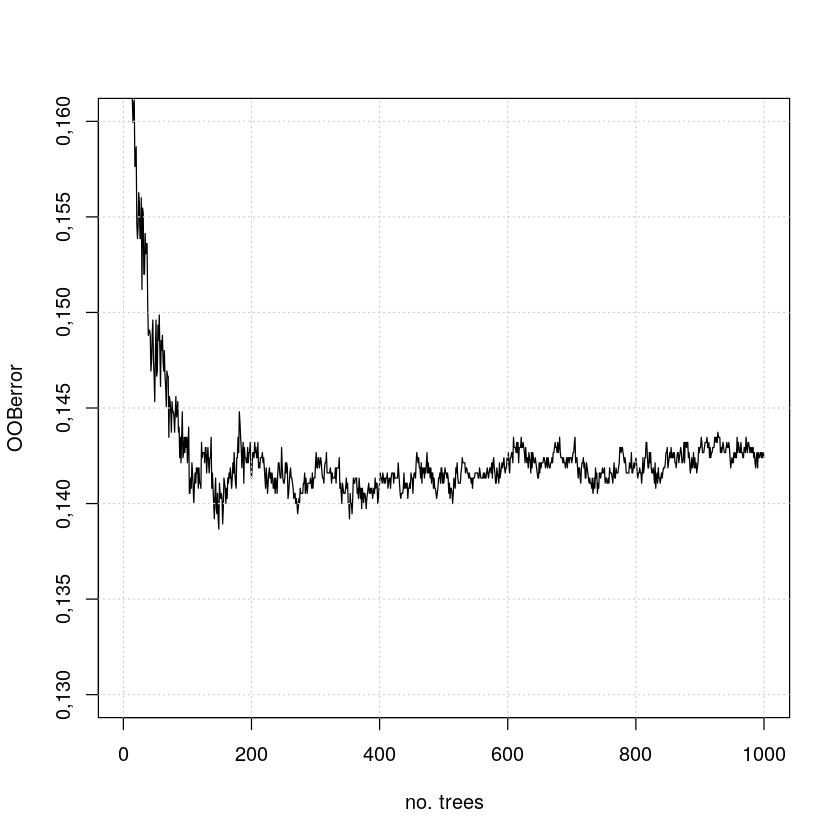

In [33]:
# Pinto los errores OOB en función del numero de arboles 
plot(rf$err.rate[, 1], type = "l", xlab = "no. trees", ylab = "OOBerror",ylim = c(0.13,0.16))
grid()

Al parecer, hay un minimo en ~200 arboles.

Decido usar 180 arboles, donde se nota el minimo de manera más evidente.

Utiliza el bosque de tamaño óptimo parar predecir la ocurrencia en el test, y conserva la predicción.


In [34]:
# Repito el entrenamiento con 180 arboles y saco la predicción de test

rf.opt <- randomForest(rain ~ ., 
                   data = meteo.rain.train,
                   ntree = 180,
                   importance=TRUE,
                   proximity=TRUE)
rf.opt

pred.rf.test = predict(rf.opt, meteo.rain.test)


Call:
 randomForest(formula = rain ~ ., data = meteo.rain.train, ntree = 180,      importance = TRUE, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 180
No. of variables tried at each split: 6

        OOB estimate of  error rate: 14,21%
Confusion matrix:
     0   1 class.error
0 2790 180  0,06060606
1  353 427  0,45256410

### Paso ahora a la parte de predicción de cantidad de lluvia

Seguidamente, tal y como hicimos con los árboles individuales, vamos a crear dos random forests para la cantidad, uno que se entrene sobre todo el dataset de train y otro que se entrene sólo sobre los días de lluvia (en el train). De nuevo, tendrás que estimar cuál es el número óptimo de árboles en cada uno de ellos (prueba bosques de hasta 1000 árboles). ¿Qué tamaños óptimos obtienes?

Utiliza los bosques óptimos encontrados para predecir la cantidad en el test, y conserva las predicciones obtenidas.


#### 1. Uso todos los eventos (lluvia y no-lluvia)

In [35]:
# Entreno un random forest para predecir la ocurrencia de la lluvia
# Uso todos los eventos (lluvia/no-lluvia)

rf.cont.full <- randomForest(y ~ ., 
                   data = meteo.cont.full.train,
                   ntree = 1000,
                   importance=TRUE,
                   proximity=TRUE)

rf.cont.full


Call:
 randomForest(formula = y ~ ., data = meteo.cont.full.train, ntree = 1000,      importance = TRUE, proximity = TRUE) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 12

          Mean of squared residuals: 25,45863
                    % Var explained: 25,14

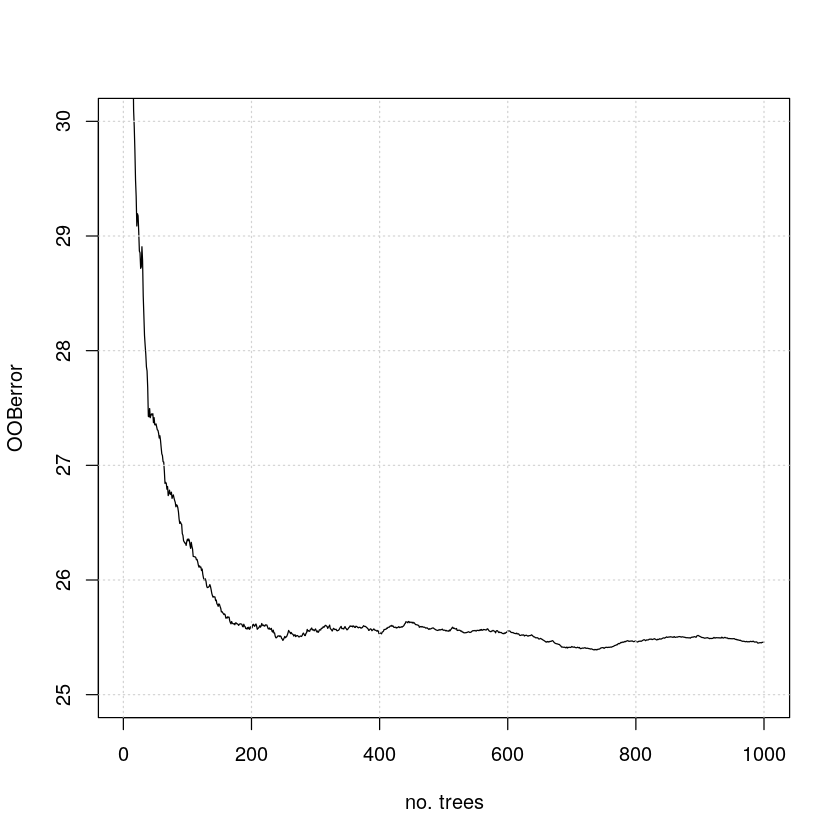

In [36]:
# Pinto los errores OOB en función del numero de arboles 
plot(rf.cont.full$mse, type = "l", xlab = "no. trees", ylab = "OOBerror", ylim = c(25,30))
grid()

Los errores OOB en este caso parecen estabilizarse alredor de 200 arboles. Luego estos siguen bajando ligeramente, pero no parece que merezca la pena complicar más el modelo vista la pequeña ganancia.

In [41]:
# Repito el entrenamiento con 200 arboles y saco la predicción de test

rf.cont.full.opt <- randomForest(y ~ ., 
                   data = meteo.cont.full.train,
                   ntree = 200,
                   importance=TRUE,
                   proximity=TRUE)
rf.cont.full.opt

pred.rf.full.opt.test = predict(rf.cont.full.opt, meteo.cont.full.test)


Call:
 randomForest(formula = y ~ ., data = meteo.cont.full.train, ntree = 200,      importance = TRUE, proximity = TRUE) 
               Type of random forest: regression
                     Number of trees: 200
No. of variables tried at each split: 12

          Mean of squared residuals: 25,71289
                    % Var explained: 24,39

#### 2. Uso solo los eventos de lluvia

In [73]:
# Entreno un random forest para predecir la ocurrencia de la lluvia
# Uso solo los eventos con lluvia

rf.cont.rain <- randomForest(y ~ ., 
                   data = meteo.cont.rain.train,
                   ntree = 1000,
                   importance=TRUE,
                   proximity=TRUE)

rf.cont.rain


Call:
 randomForest(formula = y ~ ., data = meteo.cont.rain.train, ntree = 1000,      importance = TRUE, proximity = TRUE) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 12

          Mean of squared residuals: 112,4442
                    % Var explained: 9,45

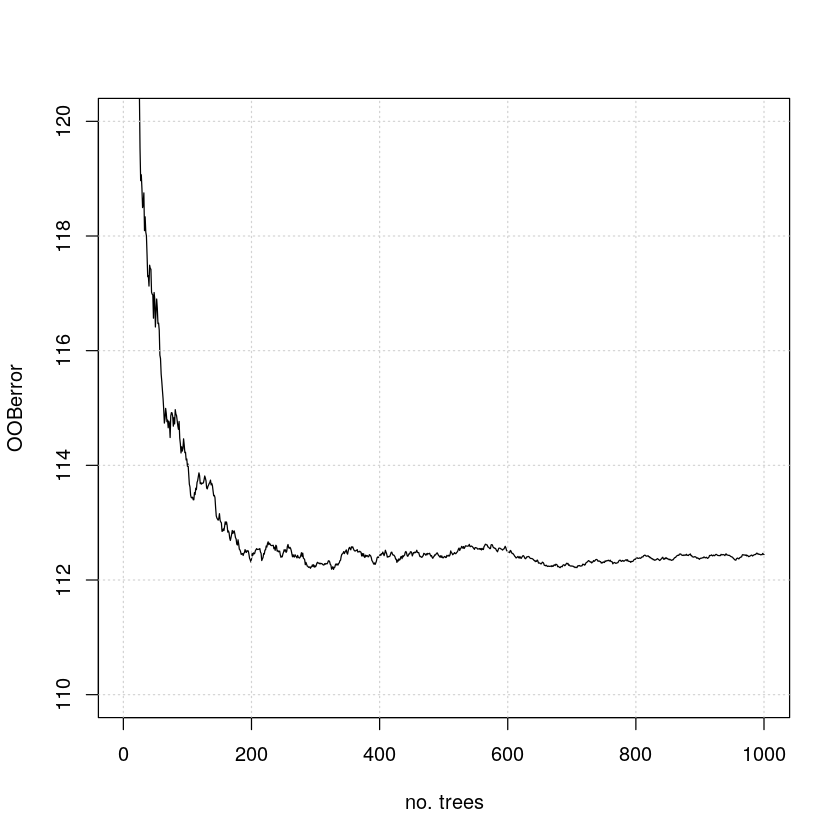

In [74]:
# Pinto los errores OOB en función del numero de arboles 
plot(rf.cont.rain$mse, type = "l", xlab = "no. trees", ylab = "OOBerror", ylim = c(110,120))
grid()

Se nota un minimo en los OOB en 600 arboles. 

No obstante, los errores siempre son muy grandes, y bajan solo de un 2-3% (sobre 115%) pasando de 200 arboles a 600. 200 arboles parecen ya suficientes para el entrenamiento.

In [75]:
# Repito el entrenamiento con 200 arboles y saco la predicción de test

rf.cont.rain.opt <- randomForest(y ~ ., 
                   data = meteo.cont.rain.train,
                   ntree = 200,
                   importance=TRUE,
                   proximity=TRUE)
rf.cont.rain.opt

pred.rf.cont.rain.opt = predict(rf.cont.rain.opt, meteo.cont.full.test)


Call:
 randomForest(formula = y ~ ., data = meteo.cont.rain.train, ntree = 200,      importance = TRUE, proximity = TRUE) 
               Type of random forest: regression
                     Number of trees: 200
No. of variables tried at each split: 12

          Mean of squared residuals: 113,3113
                    % Var explained: 8,75

### Arbol de clasificación: accuracy

In [82]:
# Mido el accuracy de la classificación binaria lluvia/no-lluvia
print("Accuracy de la clasificación lluvia/no-lluvia")
100*sum(diag(table(meteo.rain.test[,"rain"], pred.rf.test))) / length(pred.rf.test)

[1] "Accuracy de la clasificación lluvia/no-lluvia"


[1] 86,51498

In [83]:
# Y la matriz de confusión, para evaluar los falsos positivos/negativos
table(pred.rf.test, meteo.rain.test$rain)

            
pred.rf.test    0    1
           0 5422  631
           1  341  814

In [86]:
# Miro también 'a ojo' las primeras 20 predicciones, comparadas con el dataset original de test
meteo.rain.test[1:20,"rain"]
pred.rf.test[1:20]

[1] 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
Levels: 0 1

2 12 13 17 22 26 29 31 32 37 41 43 45 48 49 51 55 57 62 64 
 0  0  0  1  1  1  1  0  1  1  1  1  1  0  0  0  0  0  0  0 
Levels: 0 1

In [84]:
table(pred.rf.test)
table(meteo.rain.test$rain)

pred.rf.test
   0    1 
6053 1155 


   0    1 
5763 1445 

### Produzco las predicciones completas: multiplico la clasificación lluvia/no-lluvia por la cantidad

Construye las predicciones completas (ocurrencia×cantidad) de test y valídalas en función de las mismas métricas utilizadas en el apartado anterior.

Pregunta: Compara estos resultados con los obtenidos para árboles individuales. ¿Qué conclusiones obtienes de la comparación entre árboles individuales y random forests?

#### 1. Usando, para la cantidad, la RF entrenada con todos los eventos

In [76]:
# Predicción completa
pred.complete.full <- pred.rf.full.opt.test * (as.numeric(pred.rf.test) - 1)

[1] 5,604398

[1] 0,5841458

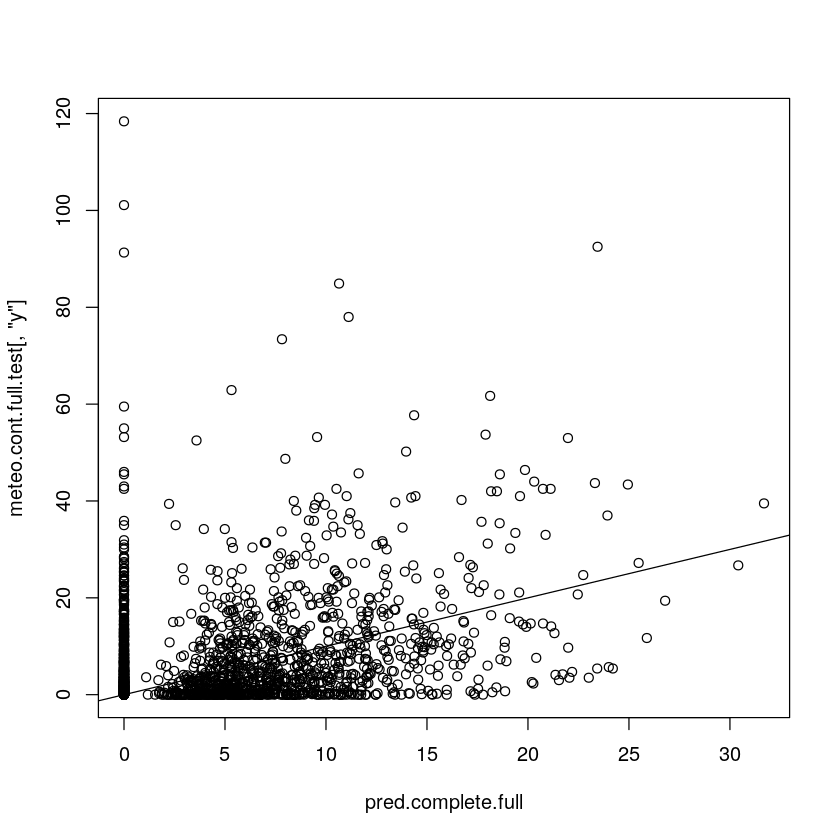

In [77]:
# Pinto los valores original contra la predicción
plot(pred.complete.full, meteo.cont.full.test[,'y'])
abline(0,1)

# RMSE - mejor si es baja
rmse.full <- sqrt(mean((meteo.cont.full.test[,'y'] - pred.complete.full)^2))
rmse.full

# Correlación - mejor si es alta
corr.full <- cor(meteo.cont.full.test[,'y'], pred.complete.full,  method = "spearman")
corr.full

#### 2. Usando, para la cantidad, la RF entrenada con solo los eventos de lluvia

In [78]:
pred.complete.rain <- pred.rf.cont.rain.opt * (as.numeric(pred.rf.test) - 1)

[1] 4,938488

[1] 0,5817244

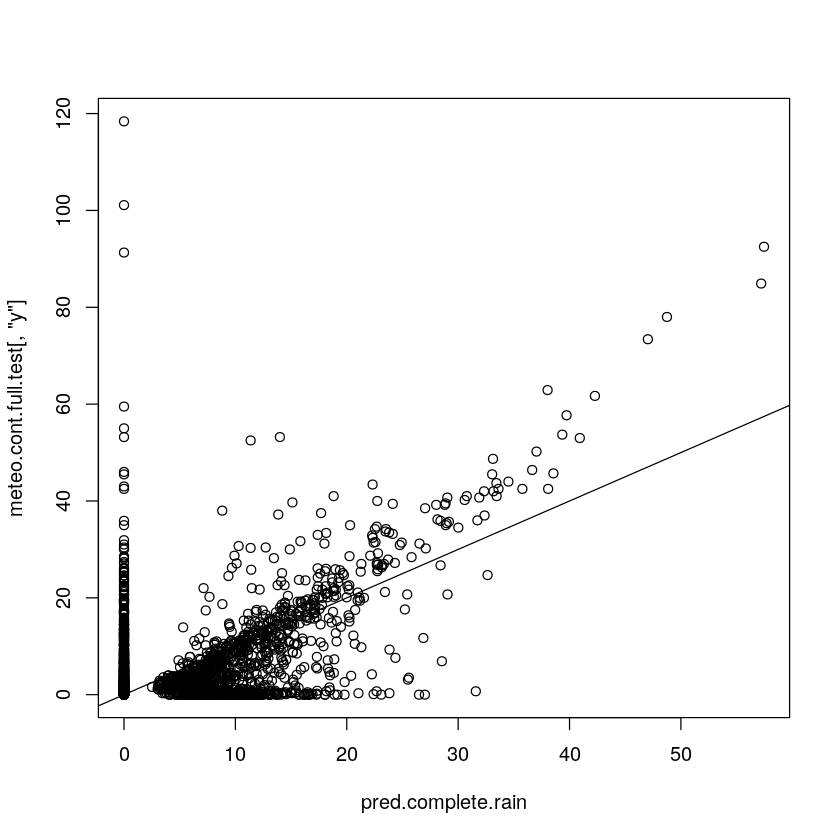

In [79]:
# Pinto los valores original contra la predicción
plot(pred.complete.rain, meteo.cont.full.test[,'y'])
abline(0,1)

# RMSE - mejor si es baja
rmse.full <- sqrt(mean((meteo.cont.full.test[,'y'] - pred.complete.rain)^2))
rmse.full

# Correlación - mejor si es alta
corr.full <- cor(meteo.cont.full.test[,'y'], pred.complete.rain,  method = "spearman")
corr.full

En este caso, se nota tanto visualmente como a través de los resultados númericos (RMSE y correlación), que el random forest entrenado sólo con días de lluvia es capaz de mejorar, aunque no drasticamente, las predicciones de lluvia, cuando se intenta predecir su cantidad.

Podemos explicar esto mirando la bondad de la predicción que obtenemos con el random forest de clasificación de días de lluvia/no lluvia, con respecto a cuanto observado en el caso de arboles simples:
- la clasificación de días de lluvia, mirando la matriz de confusión, parece significativamente mejor: aunque el accuracy sea parecido, los terminos fuera de la díagonal (falsos positivos y falsos negativos) son más pequeños. Predecir los días de lluvia sigue siendo complicado y se siguen prediciendo menos de lo que son en la realidad, pero ya hacemos mejor que simplemente tirando una moneda.

Addicionalmente, vemos que en general, la predicciones del random forest son mejores que las que obtenemos usando arboles individuales:
- el random forest es una herremienta, en principio, más potente que un singolo arbol de clasificación o regresión, ya que combina los resultados de muchos arboles para crear un clasificador más robusto y menos sujeto al sobreajuste;
- en este ejercicio, el random forest proprciona una predicción continua, que es capaz de describir más fielmente la cantidad de lluvia.

No obstante, hay que destacar que las predicciones, aunque mejoren, no lo hacen de manera drámatica.

## 4 Modelos lineales generalizados (GLMs) (1.5 puntos)

Usaremos a continuación GLMs para el mismo problema abordado en los apartados anteriores. Como ya hemos visto en otras sesiones, debemos utilizar la familia binomial con función de enlace logit (regresión logística) para clasificación y la familia Gamma con función de enlace logarítmica para la cantidad.

Comenzamos con el modelo para la ocurrencia.

Una vez tenemos el modelo, lo utilizamos para predecir en el test. Tendremos que convertir la predicción probabilística obtenida en binaria (considera un umbral 0.5).

A continuación, ajustamos el modelo de cantidad. Para ello tenemos que seleccionar previamente los días de lluvia (la familia Gamma sólo acepta valores positivos).

Utilizamos el modelo obtenido para predecir la cantidad en el test.

De nuevo, multiplicamos la ocurrencia por la cantidad para obtener la predicción completa en el test y la validamos en función de las métricas de validación que utilizamos para CART y random forests.

Pregunta: Compara estos resultados con los obtenidos para CART y random forests. ¿Qué conclusiones obtienes?

### Desarrollo punto 4

In [ ]:
# Ya tengo los datasets de entrenamiento y de test listos:

# Clasificación:
# - Todos los días (lluvia y no-lluvia):
#   - entrenamiento: meteo.rain.train
#   - test: meteo.rain.test



# Predicción continua:
# - Todos los días (lluvia y no-lluvia):
#   - entrenamiento: meteo.cont.full.train
#   - test: meteo.cont.full.test

# - Solo días de lluvia:
#   - entrenamiento: meteo.cont.rain.train
#   - test: meteo.cont.rain.test

### 4.1 Modelo lineal para la ocurrencia de lluvia

Usaremos a continuación GLMs para el mismo problema abordado en los apartados anteriores. Como ya hemos visto en otras sesiones, debemos utilizar la familia binomial con función de enlace logit (regresión logística) para clasificación y la familia Gamma con función de enlace logarítmica para la cantidad.

Comenzamos con el modelo para la ocurrencia.


In [87]:
# Entreno el modelo para la ocurrencia de la lluvia
lin.model <- glm(rain ~ ., 
                 data = meteo.rain.train, 
                 family = binomial(link = "logit"))

lin.model


Call:  glm(formula = rain ~ ., family = binomial(link = "logit"), data = meteo.rain.train)

Coefficients:
(Intercept)           X1           X2           X3           X4           X5  
  2,184e+02    4,222e-03   -4,695e-03    1,415e-03    8,344e-03   -9,540e-03  
         X6           X7           X8           X9          X10          X12  
 -2,634e-03    1,194e-03    2,526e-03   -2,121e-02    2,079e-02   -2,792e-04  
        X13          X14          X15          X18          X19          X20  
  3,494e-03    2,154e-02   -2,474e-02   -1,018e-03   -1,335e-02    1,522e-02  
        X24          X25          X83          X84          X85          X88  
  2,360e-03   -3,343e-03   -6,574e-01   -1,969e-01    2,671e-01    3,713e-02  
        X89         X125         X283         X284         X285         X289  
  1,913e-01    1,137e-01   -1,444e-03   -1,100e-02    6,464e-03    1,009e-02  
       X290         X294         X295         X299         X300         X304  
  6,747e-04   -2,959e-03

In [ ]:
# Transformo la predicción continua en categorica (lluvia/no-lluvia)
# Fijo el umbral a 0.5
out.lin.model <- lin.model$fitted.values
out.bin.lin.model <- as.double(out.lin.model > 0.5)

# Histograma de salida del modelo
hist(out.lin.model, main = "Histograma de salida del modelo")

# Histograma de salida del modelo (con variable categorica)
hist(out.bin.lin.model, main = "Histograma de salida del modelo (con variable categorica)")

Una vez tenemos el modelo, lo utilizamos para predecir en el test. 

Tendremos que convertir la predicción probabilística obtenida en binaria (considera un umbral 0.5).


In [88]:
# Preparo la predicción de clasificación de días de lluvia/no lluvia
out.test.rain <- predict(object = lin.model, newdata = meteo.rain.test);
out.bin.test.rain <- as.double(out.test.rain > 0.5)

# Tasa de acierto (test)
print("Accuracy sobre el datset de test:")
100*sum(diag(table(meteo.rain.test$rain, out.bin.test.rain))) / length(out.bin.test.rain)

print(paste("Días con lluvia (1) y sin lluvia (0) en el dataset de test:"))
table(meteo.rain.test$rain)

# Matriz de confusión de test
print("Matriz de confusión de test:")
table(meteo.rain.test$rain, out.bin.test.rain)

[1] "Accuracy sobre el datset de test:"


[1] 87,0283

[1] "Días con lluvia (1) y sin lluvia (0) en el dataset de test:"



   0    1 
5763 1445 

[1] "Matriz de confusión de test:"


   out.bin.test.rain
       0    1
  0 5561  202
  1  733  712

### 4.2 Modelo lineal para la cantidad de lluvia

A continuación, ajustamos el modelo de cantidad. Para ello tenemos que seleccionar previamente los días de lluvia (la familia Gamma sólo acepta valores positivos).

Utilizamos el modelo obtenido para predecir la cantidad en el test.



In [89]:
# Entreno el modelo para la cantidad de lluvia
# Selecciono sólo días de lluvia porque la familia de funciones Gamma
# acepta valores mayores de 0

lin.model.cont <- glm(y ~ ., 
                      data = meteo.cont.rain.train,
                      family = Gamma(link = "inverse"))

lin.model.cont


Call:  glm(formula = y ~ ., family = Gamma(link = "inverse"), data = meteo.cont.rain.train)

Coefficients:
(Intercept)           X1           X2           X3           X4           X5  
 -3,394e+00   -6,148e-05    1,603e-04   -2,311e-04    4,052e-04   -6,474e-06  
         X6           X7           X8           X9          X10          X12  
  3,424e-05   -1,477e-04    3,212e-06   -6,815e-04    7,153e-05    4,305e-05  
        X13          X14          X15          X18          X19          X20  
  2,846e-04    2,831e-04    1,564e-04   -2,464e-04    3,700e-05   -2,704e-04  
        X24          X25          X83          X84          X85          X88  
  8,920e-05    5,962e-05   -8,178e-03    1,017e-02   -7,746e-03    1,658e-02  
        X89         X125         X283         X284         X285         X289  
 -4,330e-03   -2,456e-03    1,585e-04   -1,526e-05   -1,069e-04   -5,919e-05  
       X290         X294         X295         X299         X300         X304  
  3,304e-04    8,398e-0

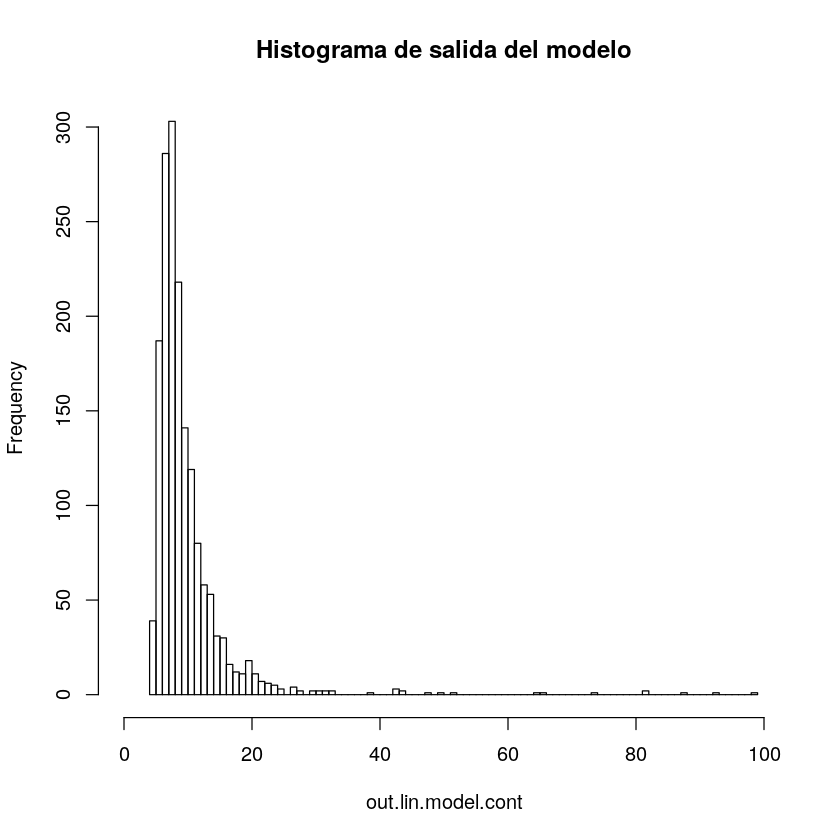

In [90]:
# Miro la salida del modelo
out.lin.model.cont <- lin.model.cont$fitted.values

# Histograma de salida del modelo
hist(out.lin.model.cont,
     breaks = 100,
     xlim = c(0,100),
     main = "Histograma de salida del modelo")

In [91]:
# Miro como el modelo predice sobre el dataset de test
# con solo días de lluvia
out.test.rain.cont <- predict(object = lin.model.cont, 
                              newdata = meteo.cont.rain.test,
                              type = "response")
out.test.rain.cont[1:20]

3        27        28        33        38        42        45        48 
11,019701 12,569223  5,576653  8,744578  8,770043  7,796492  6,888883  9,041720 
       49        72        76        78        81        93        94        98 
 9,408484  6,388261  8,990046  8,129143  8,393595  5,156570  7,294123 13,025908 
      102       138       191       257 
14,116164  5,470338  5,085111  7,543288

In [92]:
# Miro como el modelo predice sobre el dataset de test
# con días con lluvia y dias sin lluvia
out.train.rain.cont.all <- predict(object = lin.model.cont, 
                              newdata = meteo.cont.full.test,
                              type = "response")
out.train.rain.cont.all[1:20]

2        12        13        17        22        26        29        31 
 9,799535  4,701642  6,119850  9,302767  9,017674 16,170426  6,883920  9,523129 
       32        37        41        43        45        48        49        51 
11,824924  7,921460 92,410644 11,236559  6,888883  9,041720  9,408484  6,669130 
       55        57        62        64 
10,261290  6,473537  5,260631  5,597917

### 4.3 Evaluación de las predicciones

De nuevo, multiplicamos la ocurrencia por la cantidad para obtener la predicción completa en el test y la validamos en función de las métricas de validación que utilizamos para CART y random forests.

Pregunta: Compara estos resultados con los obtenidos para CART y random forests. ¿Qué conclusiones obtienes?

In [94]:
# Produzco las predicciones completas: 
# multiplico la clasificación lluvia/no-lluvia por la cantidad

glm.complete.rain <- out.train.rain.cont.all * (as.numeric(out.bin.test.rain))

for (i in 1:20){
    print(paste(
        format(round(glm.complete.rain[i],2), nsmall = 2), "    ",
        format(round(meteo.cont.full.test[i,1],2), nsmall = 2))
    )
}

[1] "0,00      0,60"
[1] "0,00      0,00"
[1] "0,00      0,00"
[1] "0,00      21,70"
[1] "0,00      0,00"
[1] "16,17      19,50"
[1] "6,88      6,70"
[1] "0,00      20,60"
[1] "11,82      26,70"
[1] "7,92      9,40"
[1] "92,41      53,70"
[1] "11,24      2,50"
[1] "6,89      12,90"
[1] "0,00      6,70"
[1] "9,41      16,60"
[1] "0,00      2,90"
[1] "0,00      0,00"
[1] "0,00      0,00"
[1] "0,00      0,00"
[1] "0,00      0,20"


[1] 5,665664

[1] 0,5603976

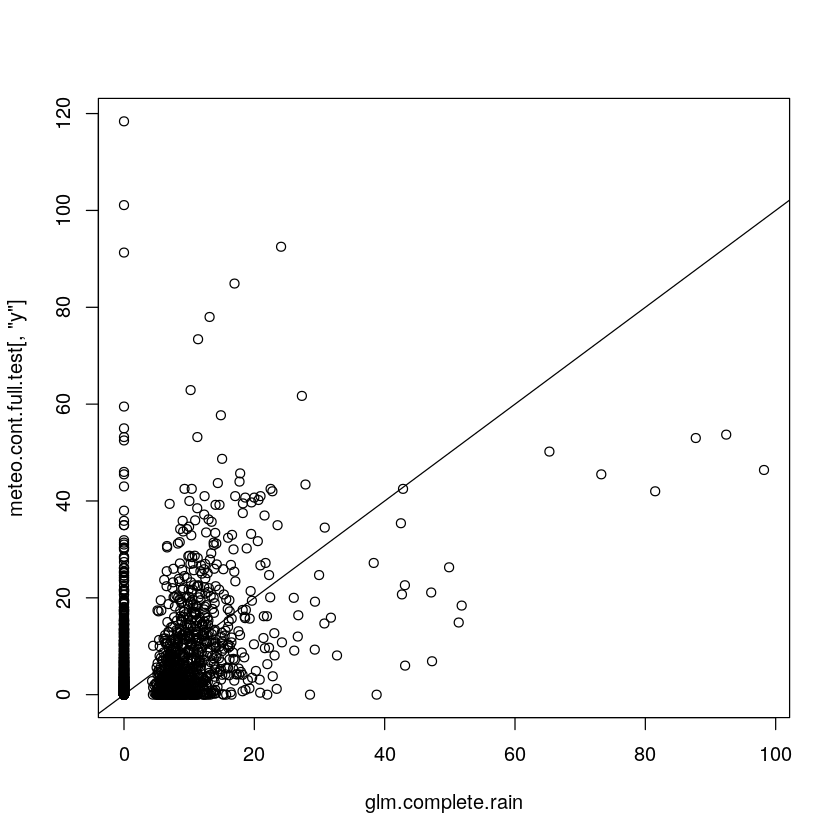

In [95]:
# Pinto los valores original contra la predicción
plot(glm.complete.rain, meteo.cont.full.test[,'y'])
abline(0,1)

# RMSE - mejor si es baja
rmse.full <- sqrt(mean((meteo.cont.full.test[,'y'] - glm.complete.rain)^2))
rmse.full

# Correlación - mejor si es alta
corr.full <- cor(meteo.cont.full.test[,'y'], glm.complete.rain,  method = "spearman")
corr.full

Como en este caso, ha sido posible entrenar el modelo solo con días de lluvia para la predicción de la cantidad de lluvia, pasamos directamente a comparar los resultados con los obtenidos con arboles y random forest.

Como primera observación, se nota que la clasificación de días de lluvia/no lluvia se parece a la que obtenemos usando arboles individuales o random forest.

Por otro lado, la cantidad de lluvia se predice con una RMSE y con un nivel de correlación con el dataset original parecida a la dada por el random forest: para este tipo de problema, un simple modelo lineal es suficiente para obtener los mismo resultados que un más complejo random forest, que necesita más tiempo para el entrenamiento y más cuidado a la hora de elegir los parametros (e.g. el número de arboles).

## 5 k nearest neighbors (k-NN) (1.5 puntos)

La última de las técnicas a utilizar será vecinos cercanos (ten en cuenta que en este caso ya no tendremos que predecir por separado ocurrencia y cantidad). Comenzaremos por una versión de k-NN en la que sólo se considere el vecino más cercano (utiliza la función knn.reg del paquete FNN).

Nota: Recuerda que en la técnica k-NN es muy importante pre-procesar adecuadamente (estandarizar) los predictores.

Como vimos en su día, el único parámetro a ajustar en la técnica k-NN es k (número de vecinos). Utilizaremos el paquete caret para encontrar el k óptimo en nuestro problema. Para ello, considera una cross-validación con 10 folds sobre el dataset de train y barre todos los k impares desde 1 a 50.

Utiliza este k óptimo para predecir en el test.

Valida las dos predicciones (con k=1 y con k=óptimo) en el test, en función de las medidas que se han ido utilizando en los apartados anteriores.

Pregunta: ¿Qué diferencias obtienes entre las dos versiones utilizadas de la técnica k-NN? ¿A qué se deben?

### Desarrollo punto 5

In [ ]:
# Ya tengo los datasets de entrenamiento y de test listos:

# Clasificación:
# - Todos los días (lluvia y no-lluvia):
#   - entrenamiento: meteo.rain.train
#   - test: meteo.rain.test

# Predicción continua:
# - Todos los días (lluvia y no-lluvia):
#   - entrenamiento: meteo.cont.full.train
#   - test: meteo.cont.full.test
#
# - Solo días de lluvia:
#   - entrenamiento: meteo.cont.rain.train
#   - test: meteo.cont.rain.test

La última de las técnicas a utilizar será vecinos cercanos (ten en cuenta que en este caso ya no tendremos que predecir por separado ocurrencia y cantidad). 
Comenzaremos por una versión de k-NN en la que sólo se considere el vecino más cercano (utiliza la función knn.reg del paquete FNN).

Nota: Recuerda que en la técnica k-NN es muy importante pre-procesar adecuadamente (estandarizar) los predictores.

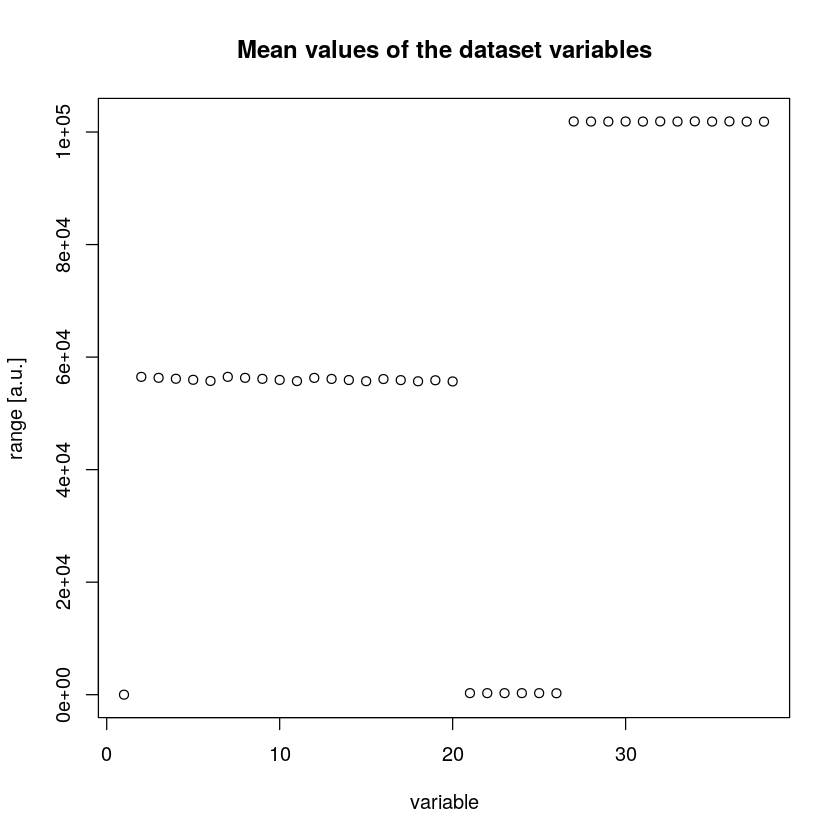

In [97]:
# Miro el rango de las variables
plot(1:38,apply(meteo.cont.full.train,2,mean),
    xlab = "variable",
    ylab = "range [a.u.]",
    main = "Mean values of the dataset variables")

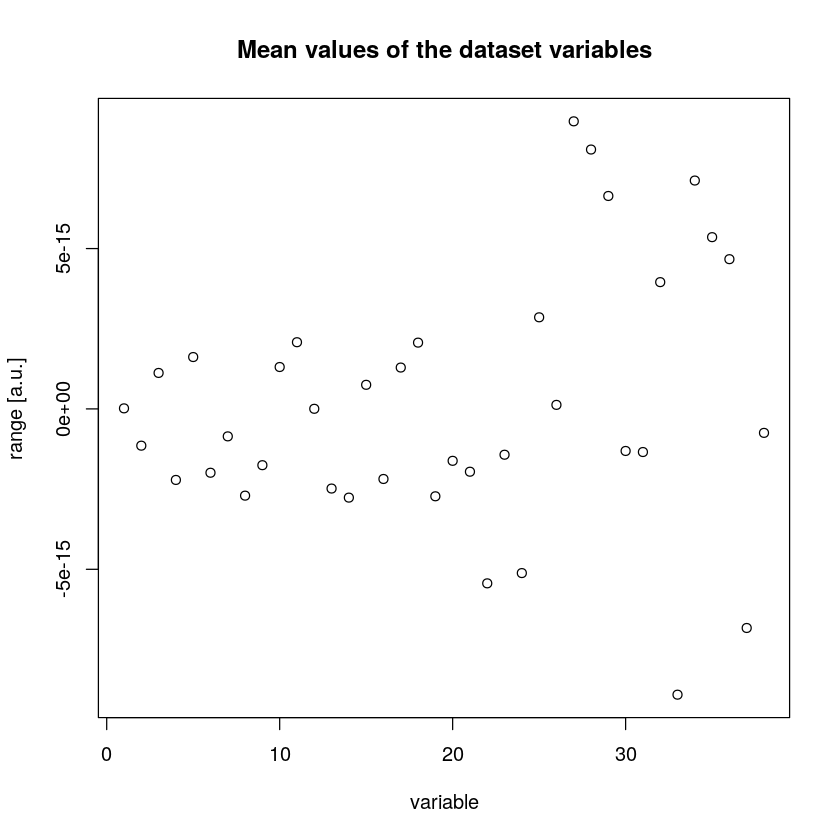

In [98]:
# Uso scale para que todas las variables tengan el mismo order de magnitud

# Dataset de entrenamiento (en el caso de knn, más bien de calibración)
meteo.cont.full.train.scale <- scale(meteo.cont.full.train, center = TRUE, scale = TRUE)

# Dataset de test
meteo.cont.full.test.scale <- scale(meteo.cont.full.test, center = TRUE, scale = TRUE)

# Miro el rango de las variables después de haber usado scale
plot(1:38,apply(meteo.cont.full.train.scale,2,mean),
    xlab = "variable",
    ylab = "range [a.u.]",
    main = "Mean values of the dataset variables")

Como vimos en su día, el único parámetro a ajustar en la técnica k-NN es k (número de vecinos). 

Utilizaremos el paquete caret para encontrar el k óptimo en nuestro problema. 

Para ello, considera una cross-validación con 10 folds sobre el dataset de train y barre todos los k impares desde 1 a 50.

In [99]:
# Cargo las librerias necesarias
library(FNN)
library(caret)

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




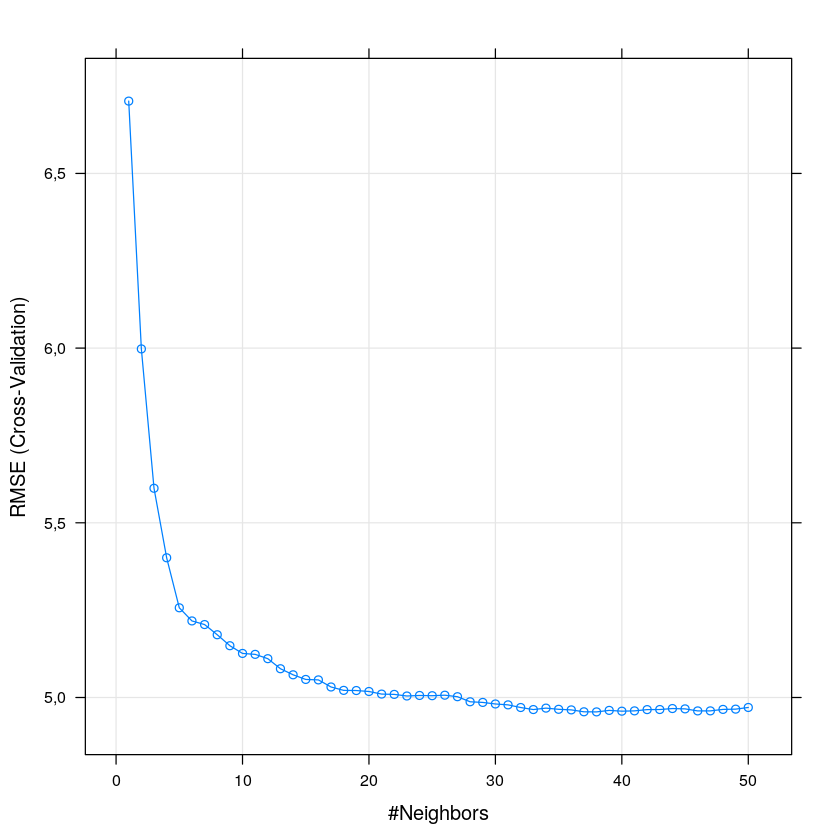

In [100]:
ctrl <- trainControl(method = "cv", 
                     number = 10)

# cambio el número de vecinos cercanos
knn <- train(y ~ ., 
             data = meteo.cont.full.train, 
             method = "knn", 
             preProcess = c("center", "scale"), 
             trControl = ctrl,
             tuneGrid = expand.grid(k = 1:50))

plot(knn)

# knn.reg(train, test = NULL, y, k = 3, algorithm=c("kd_tree", "cover_tree", "brute"))

El número de vecinos utilizados no parece afectar mucho el error de KNN: como se nota, el rango de RMSE va de 5 a 6.5 cuando pasamos de 1 a 50 vecinos utilizados.

En particular, con 20 vecinos, la bajada de la RMSE ya se para a un valor de 5%, por lo cual k = 20 vecinos es el número que vamos a considerar como óptimo.

Utiliza este k óptimo para predecir en el test.

In [125]:
# Predigo en el dataset de test usando k = 20 vecinos cercanos
k = 20

pred.knn.opt <- knn.reg(train = scale(meteo.cont.full.train[,-1]), 
                        test = scale(meteo.cont.full.test[,-1]), 
                        y = meteo.cont.full.train$y, 
                        k = k)


In [118]:
# Ahora lo mismo, pero con solo 1 vecino (K = 1)
k = 1

pred.knn.1 <- knn.reg(train = scale(meteo.cont.full.train[,-1]), 
                      test = scale(meteo.cont.full.test[,-1]), 
                      y = meteo.cont.full.train$y, 
                      k = k)

Valida las dos predicciones (con k=1 y con k=óptimo) en el test, en función de las medidas que se han ido utilizando en los apartados anteriores.



[1] 5,572761

[1] 0,6159329

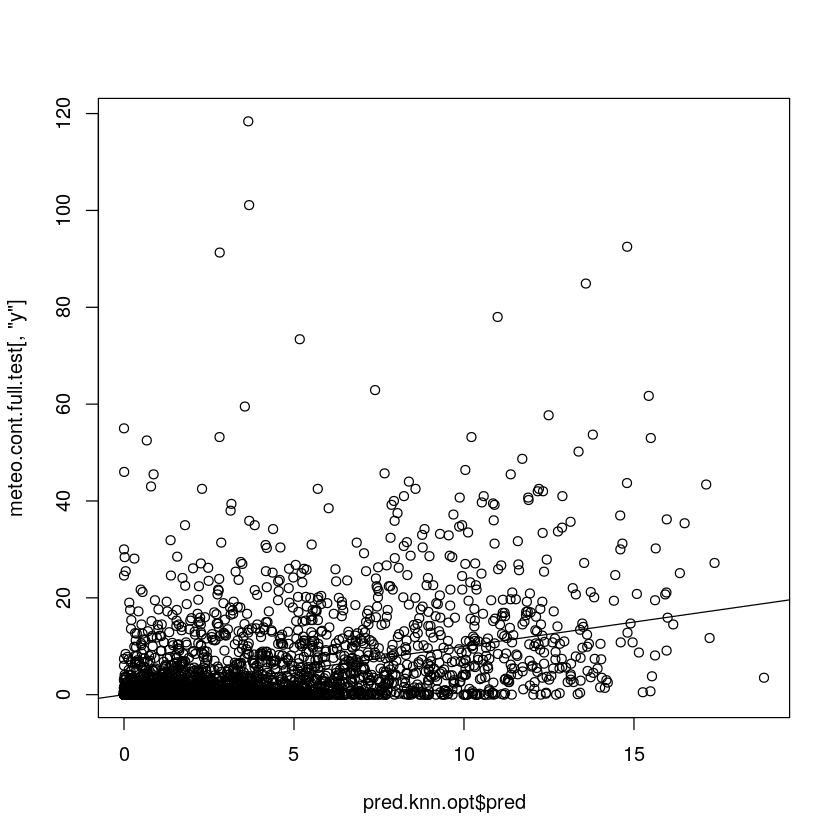

In [141]:
# Pinto los valores original contra la predicción - caso k = 20
plot(pred.knn.opt$pred, meteo.cont.full.test[,'y'])
abline(0,1)

# RMSE - mejor si es baja
rmse.full <- sqrt(mean((meteo.cont.full.test[,'y'] - pred.knn.opt$pred)^2))
rmse.full

# Correlación - mejor si es alta
corr.full <- cor(meteo.cont.full.test[,'y'], pred.knn.opt$pred,  method = "spearman")
corr.full

[1] 6,772485

[1] 0,529348

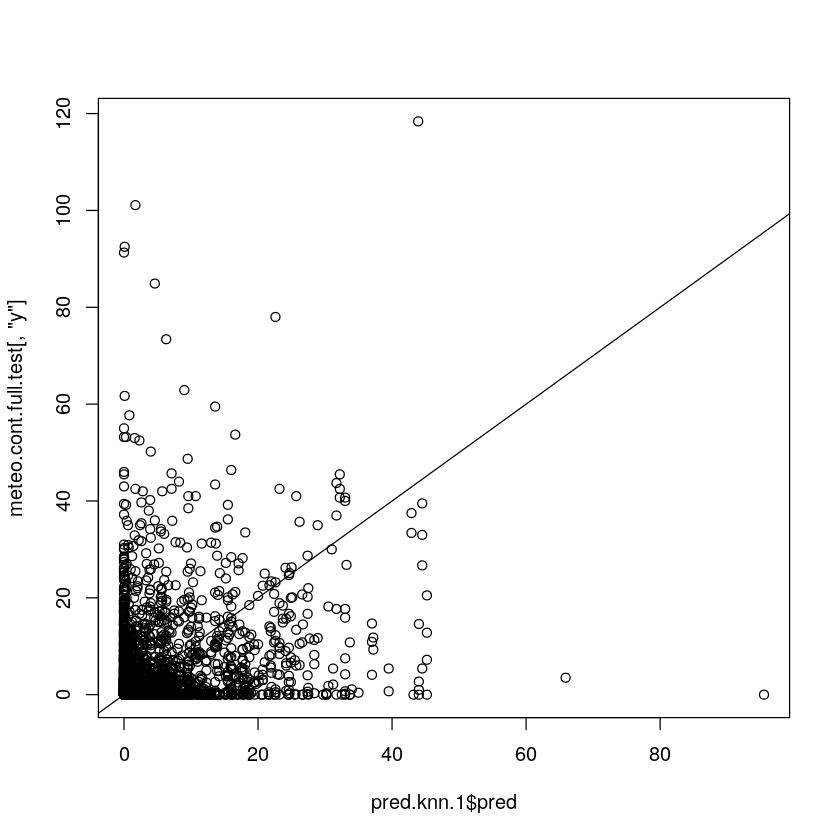

In [140]:
# Pinto los valores original contra la predicción - caso k = 1
plot(pred.knn.1$pred, meteo.cont.full.test[,'y'])
abline(0,1)

# RMSE - mejor si es baja
rmse.full <- sqrt(mean((meteo.cont.full.test[,'y'] - pred.knn.1$pred)^2))
rmse.full

# Correlación - mejor si es alta
corr.full <- cor(meteo.cont.full.test[,'y'], pred.knn.1$pred,  method = "spearman")
corr.full

Pregunta: ¿Qué diferencias obtienes entre las dos versiones utilizadas de la técnica k-NN? ¿A qué se deben?

La predicción que se obtiene usando el numero optimo de vecinos cercanos (en este caso 20), resulta más fiable que la predicción dada usando un solo vecino, como demuestra el RMSE más pequeño y la correlación más alta con el valor observado de la cantidad de lluvia.

Por otro lado, esta capacidad de generalización se 'paga' perdiendo parte del rango de precipitaciones presente en el dataset de entrenamiento. En otras palabras, observando el scatter plot de observaciones frente a predicciones, se nota que estas tienen un rango muy limitado en el caso de entrenamiento optimo (la máxima cantidad de lluvia predicha es de 20mm), mientras que en el caso de entrenamiento con un solo vecino, se llega casi hasta 100mm (la observacioes llegan, aunque en un solo caso, a 120mm).
Otro factor que hay que considerar es que, no obstante el dataset utilizado en ese ejemplo sea muy pequeño, el tiempo necesario para producir las predicciones en el caso de 1 solo vecino es sensiblemente más corto con respecto al tiempo necesario cuando se usan 20 vecinos.

Comparando con los otros método de predicción, los resultados parecen compatibles con los de los demás metodos.
En particular, aunque el RMSE se quede más grande que, por ejemplo, el proporcionado por el random forest, la correlación con las observaciones es la más alta.

## 6 Conclusiones generales (2 puntos)

A la vista de los resultados obtenidos, argumenta razonadamente qué técnica o técnicas serían las mejores para la predicción de lluvia en Lisboa. Justifica tu respuesta.

Aquí hago un resumen/tabla con todas la cantidades 
- RMSE
- accuracy,
- matrices de confusion

y argumento un poco/hago pruebas --> si clasifico con algo y regresiono con algo distinto, etc.